# Semantic Retrieval for Scientific Documents

This notebook presents an semantic retrieval system for scientific documents, trained and evaluated on the SciFact dataset. The goal of this project is to investigate how modern neural embedding models, combined with appropriate training strategies, can improve document retrieval performance in scientific domains.

## Project Overview

The main components of this notebook include:

- Fine-tuning sentence embedding models using the `sentence-transformers` framework
- Training with the MultipleNegativesRankingLoss objective to learn discriminative representations
- Converting the SciFact dataset into BEIR-compatible format for standardized evaluation
- Evaluating retrieval performance using multiple ranking metrics
- Comparing neural retrieval approaches with traditional baselines such as Word2Vec

## 1. Environment Setup and Dependencies

In [7]:
# If running in Colab, uncomment the line below to install dependencies
!pip install sentence-transformers datasets pandas scikit-learn torch accelerate beir

In [8]:
import logging
import json
import math
from pathlib import Path
from collections import defaultdict
from typing import Dict, Set, List, Tuple, Optional, Any, Union
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    from IPython import get_ipython  # type: ignore
except Exception:  # pragma: no cover

    def get_ipython():
        return None


try:
    from IPython.core.getipython import get_ipython
except Exception:  # pragma: no cover

    def get_ipython():
        return None


# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

## 2. Data Loading and Preprocessing

We use the BeIR/scifact-generated-queries dataset, a scientific literature retrieval dataset.


In [9]:
def load_scifact_raw(output_dir: str = "./data/raw"):
    """
    Load BeIR/scifact-generated-queries dataset from HuggingFace
    """
    from datasets import load_dataset

    raw_dir = Path(output_dir)
    raw_dir.mkdir(parents=True, exist_ok=True)

    # Load dataset
    logger.info("Loading SciFact dataset from HuggingFace...")
    ds = load_dataset("BeIR/scifact-generated-queries")
    df = ds["train"].to_pandas()  # type: ignore

    # Save raw data
    raw_path = raw_dir / "scifact_raw.csv"
    df.to_csv(raw_path, index=False)  # type: ignore
    logger.info(f"Raw data saved to {raw_path}")
    logger.info(f"Dataset size: {len(df)} rows")  # type: ignore

    return df  # type: ignore

In [10]:
def preprocess_scifact(raw_df: pd.DataFrame, output_dir: str = "./data/processed"):
    """
    Preprocess SciFact dataset and generate BEIR-format training data

    Output files:
    - scifact_pairs.csv: Query-document pairs
    - scifact_corpus.csv: Deduplicated document corpus
    - beir_format/corpus.jsonl: BEIR-format corpus
    - beir_format/queries.jsonl: BEIR-format queries
    - beir_format/qrels/train.tsv: Training set relevance labels (70%)
    - beir_format/qrels/dev.tsv: Validation set relevance labels (10%)
    - beir_format/qrels/test.tsv: Test set relevance labels (20%)
    """
    processed_dir = Path(output_dir)
    processed_dir.mkdir(parents=True, exist_ok=True)

    # Process data
    df = raw_df[["_id", "title", "text", "query"]].copy()
    df = df.dropna(subset=["text", "query"])  # type: ignore
    df = df.rename(columns={"_id": "doc_id"})

    # Data cleaning
    df["title"] = df["title"].fillna("").astype(str).str.strip()
    df["text"] = df["text"].fillna("").astype(str).str.strip()
    df["query"] = df["query"].astype(str).str.strip()

    # Combine title and text
    df["content"] = df["title"] + ". " + df["text"]

    # Assign ID to each unique query
    df = df.reset_index(drop=True)
    df["query_id"] = pd.factorize(df["query"])[0]

    # Save query-document pairs
    pairs_path = processed_dir / "scifact_pairs.csv"
    df.to_csv(pairs_path, index=False)
    logger.info(f"Query-doc pairs saved to {pairs_path}")

    # Save deduplicated corpus
    corpus = (
        df[["doc_id", "content"]]
        .drop_duplicates(subset=["doc_id"])  # type: ignore
        .reset_index(drop=True)
    )
    corpus_path = processed_dir / "scifact_corpus.csv"
    corpus.to_csv(corpus_path, index=False)
    logger.info(f"Corpus saved to {corpus_path} ({len(corpus)} documents)")

    # Create BEIR-format data
    beir_dir = processed_dir / "beir_format"
    beir_dir.mkdir(parents=True, exist_ok=True)
    qrels_dir = beir_dir / "qrels"
    qrels_dir.mkdir(parents=True, exist_ok=True)

    # Write corpus.jsonl
    corpus_jsonl_path = beir_dir / "corpus.jsonl"
    with open(corpus_jsonl_path, "w", encoding="utf-8") as f:
        for _, row in corpus.iterrows():
            doc = {
                "_id": str(row["doc_id"]),
                "text": row["content"],
                "title": "",
            }
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
    logger.info(f"BEIR corpus saved to {corpus_jsonl_path}")

    # Write queries.jsonl
    queries_jsonl_path = beir_dir / "queries.jsonl"
    unique_queries = df[["query_id", "query"]].drop_duplicates(subset=["query_id"])  # type: ignore
    with open(queries_jsonl_path, "w", encoding="utf-8") as f:
        for _, row in unique_queries.iterrows():
            query = {"_id": str(row["query_id"]), "text": row["query"]}
            f.write(json.dumps(query, ensure_ascii=False) + "\n")
    logger.info(f"BEIR queries saved to {queries_jsonl_path}")

    # Split into train/dev/test sets (70/10/20)
    unique_query_ids = df["query_id"].unique()
    train_dev_query_ids, test_query_ids = train_test_split(
        unique_query_ids, test_size=0.2, random_state=42
    )
    train_query_ids, dev_query_ids = train_test_split(
        train_dev_query_ids, test_size=0.125, random_state=42
    )

    train_df = df[df["query_id"].isin(train_query_ids)]
    dev_df = df[df["query_id"].isin(dev_query_ids)]
    test_df = df[df["query_id"].isin(test_query_ids)]

    # Write qrels files
    for split_name, split_df in [
        ("train", train_df),
        ("dev", dev_df),
        ("test", test_df),
    ]:
        qrels_path = qrels_dir / f"{split_name}.tsv"
        with open(qrels_path, "w", encoding="utf-8") as f:
            for _, row in split_df.iterrows():
                f.write(f"{row['query_id']}\t{row['doc_id']}\t1\n")
        logger.info(f"{split_name} qrels saved to {qrels_path} ({len(split_df)} pairs)")

    logger.info(f"\nData preprocessing completed!")
    logger.info(f"Train: {len(train_query_ids)} queries, {len(train_df)} pairs")
    logger.info(f"Dev: {len(dev_query_ids)} queries, {len(dev_df)} pairs")
    logger.info(f"Test: {len(test_query_ids)} queries, {len(test_df)} pairs")

    return beir_dir

## 3. Data Loading Utilities


In [11]:
def load_qrels(qrels_path: Path) -> Dict[str, Set[str]]:
    """Load qrels file and return query_id -> {doc_ids} mapping"""
    query_to_docs = defaultdict(set)

    with open(qrels_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                query_id = parts[0]
                doc_id = parts[1]
                query_to_docs[query_id].add(doc_id)

    return dict(query_to_docs)


def load_queries(queries_path: Path) -> Dict[str, str]:
    """Load queries.jsonl file and return query_id -> query_text mapping"""
    queries = {}

    with open(queries_path, "r", encoding="utf-8") as f:
        for line in f:
            query = json.loads(line)
            queries[query["_id"]] = query["text"]

    return queries


def load_corpus(corpus_path: Path) -> Dict[str, str]:
    """Load corpus.jsonl file and return doc_id -> doc_text mapping"""
    corpus = {}

    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            doc = json.loads(line)
            corpus[doc["_id"]] = doc["text"]

    return corpus

## 4. Model Training

Fine-tune embedding models using sentence-transformers library with MultipleNegativesRankingLoss.

In [12]:
# Training configuration
# Use MiniLM for zero-shot / fine-tuning baseline in this notebook
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 64
EPOCHS = 5
WARMUP_RATIO = 0.1
LEARNING_RATE = 3e-5
OUTPUT_DIR = "/content/drive/semantic-retrieval/models/finetuned-mnrl"

IN_COLAB = "google.colab" in str(get_ipython())
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    BASE_DIR = Path("/content/drive/MyDrive/semantic-retrieval")
    OUTPUT_DIR = str(BASE_DIR / "models/finetuned-mnrl")
    DATA_DIR = str(BASE_DIR / "data")
    RESULTS_DIR = str(BASE_DIR / "results")
else:
    BASE_DIR = Path(".")
    OUTPUT_DIR = "./models/finetuned-mnrl"
    DATA_DIR = "./data"
    RESULTS_DIR = "./results"

Mounted at /content/drive


In [13]:
def load_training_data(data_dir: Path) -> list:
    """
    Load training data and convert to InputExample format

    For MultipleNegativesRankingLoss, we only need (query, positive_doc) pairs.
    Negative samples are drawn from other examples in the same batch.
    """
    from sentence_transformers import InputExample

    qrels_path = data_dir / "qrels" / "train.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info("Loading training data...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)

    # Create training examples
    examples = []
    for query_id, doc_ids in query_to_docs.items():
        if query_id not in queries:
            continue

        query_text = queries[query_id]

        for doc_id in doc_ids:
            if doc_id not in corpus:
                continue

            doc_text = corpus[doc_id]
            examples.append(InputExample(texts=[query_text, doc_text]))

    logger.info(f"Created {len(examples)} training examples")
    return examples


def create_evaluator(data_dir: Path, split: str = "dev"):
    """
    Create InformationRetrievalEvaluator for validation during training
    """
    from sentence_transformers.evaluation import InformationRetrievalEvaluator

    qrels_path = data_dir / "qrels" / f"{split}.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info(f"Loading {split} data for evaluation...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)

    # Filter queries and documents
    eval_queries = {qid: queries[qid] for qid in query_to_docs if qid in queries}
    eval_corpus = corpus

    # Convert qrels format
    eval_qrels: Dict[str, Set[str]] = {
        qid: set(doc_ids)
        for qid, doc_ids in query_to_docs.items()
        if qid in eval_queries
    }

    logger.info(f"Evaluator: {len(eval_queries)} queries, {len(eval_corpus)} documents")

    return InformationRetrievalEvaluator(
        queries=eval_queries,
        corpus=eval_corpus,
        relevant_docs=eval_qrels,
        name=split,
        ndcg_at_k=[10, 100],
        precision_recall_at_k=[10, 100],
        map_at_k=[100],
        mrr_at_k=[10],
        show_progress_bar=True,
    )

In [14]:
def train_model(data_dir: Path, output_dir: str = OUTPUT_DIR):
    """
    Train the embedding model
    """
    from sentence_transformers import SentenceTransformer, losses
    from torch.utils.data import DataLoader

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Load model
    logger.info(f"Loading model: {MODEL_NAME}")
    model = SentenceTransformer(MODEL_NAME)

    # Load training data
    train_examples = load_training_data(data_dir)
    train_dataloader = DataLoader(
        train_examples,  # type: ignore
        shuffle=True,
        batch_size=BATCH_SIZE,
    )

    # Setup loss function
    train_loss = losses.MultipleNegativesRankingLoss(model)

    # Create validation evaluator
    dev_evaluator = create_evaluator(data_dir, split="dev")

    # Calculate training steps
    total_steps = len(train_dataloader) * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)

    logger.info(f"\nTraining configuration:")
    logger.info(f"  Model: {MODEL_NAME}")
    logger.info(f"  Batch size: {BATCH_SIZE}")
    logger.info(f"  Epochs: {EPOCHS}")
    logger.info(f"  Total steps: {total_steps}")
    logger.info(f"  Warmup steps: {warmup_steps}")
    logger.info(f"  Learning rate: {LEARNING_RATE}")
    logger.info(f"  Output directory: {output_path}")

    # Start training
    logger.info("\nStarting training...")
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=dev_evaluator,
        epochs=EPOCHS,
        warmup_steps=warmup_steps,
        optimizer_params={"lr": LEARNING_RATE},
        output_path=str(output_path),
        evaluation_steps=len(train_dataloader) // 2,  # Evaluate twice per epoch
        save_best_model=True,
        show_progress_bar=True,
    )

    logger.info(f"\nTraining completed! Model saved to: {output_path}")

    # Final evaluation on test set
    logger.info("\nRunning final evaluation on test set...")
    test_evaluator = create_evaluator(data_dir, split="test")
    test_results = test_evaluator(model, output_path=str(output_path))

    logger.info("\n" + "=" * 50)
    logger.info("Final Test Results:")
    for metric, value in test_results.items():
        logger.info(f"  {metric}: {value:.4f}")
    logger.info("=" * 50)

    return model

## 5. Evaluation Metrics

Implement standard information retrieval evaluation metrics.

In [15]:
# Type alias for ground truth
GroundTruth = Union[str, List[str], Set[str]]

In [16]:
def traditional_eval(samples: List[Dict[str, Any]], k: int = 10) -> Dict[str, float]:
    """
    Evaluation for retrieval with single or multi-ground-truth.

    Args:
        samples: List of samples in the format:
            [{
                "question": str,
                "contexts": List[str],  # ranked top-K doc_ids
                "ground_truth": str | list | set  # gold doc_id(s)
            }]
        k: Cutoff position for evaluation

    Returns:
        Dictionary containing various metrics
    """

    def to_set(gt: GroundTruth) -> Set[str]:
        if isinstance(gt, set):
            return set(str(x) for x in gt)
        if isinstance(gt, list):
            return set(str(x) for x in gt)
        # single string / single id
        return {str(gt)}

    def hit_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        return 1.0 if any(r in gt_set for r in results[:k]) else 0.0

    def precision_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        if k <= 0:
            return 0.0
        hits = sum(1 for r in results[:k] if r in gt_set)
        return hits / k

    def recall_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        if not gt_set:
            return 0.0
        hits = sum(1 for r in results[:k] if r in gt_set)
        return hits / len(gt_set)

    def mrr(gt_set: Set[str], results: List[str]) -> float:
        for rank, r in enumerate(results, start=1):
            if r in gt_set:
                return 1.0 / rank
        return 0.0

    def average_precision_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        """
        AP@K for multi-relevant:
          AP = (1 / min(|GT|, K)) * sum_{i=1..K} Precision@i * rel_i
        """
        if not gt_set:
            return 0.0

        hits = 0
        s = 0.0
        for i, r in enumerate(results[:k], start=1):
            if r in gt_set:
                hits += 1
                s += hits / i
        return s / min(len(gt_set), k)

    def ndcg_at_k(gt_set: Set[str], results: List[str], k: int) -> float:
        # binary relevance
        dcg = 0.0
        for i, r in enumerate(results[:k], start=1):
            rel = 1.0 if r in gt_set else 0.0
            dcg += rel / math.log2(i + 1)

        # ideal DCG: all relevant docs first
        ideal_rels = [1.0] * min(len(gt_set), k)
        idcg = 0.0
        for i, rel in enumerate(ideal_rels, start=1):
            idcg += rel / math.log2(i + 1)

        return dcg / idcg if idcg > 0 else 0.0

    hits, precisions, recalls, mrrs, aps, ndcgs = [], [], [], [], [], []

    for s in samples:
        gt_set = to_set(s["ground_truth"])
        results = [str(x) for x in s["contexts"]]

        hits.append(hit_at_k(gt_set, results, k))
        precisions.append(precision_at_k(gt_set, results, k))
        recalls.append(recall_at_k(gt_set, results, k))
        mrrs.append(mrr(gt_set, results))
        aps.append(average_precision_at_k(gt_set, results, k))
        ndcgs.append(ndcg_at_k(gt_set, results, k))

    n = len(samples) if samples else 1
    return {
        f"Hit@{k}": sum(hits) / n,
        f"Precision@{k}": sum(precisions) / n,
        f"Recall@{k}": sum(recalls) / n,
        "MRR": sum(mrrs) / n,
        f"MAP@{k}": sum(aps) / n,
        f"NDCG@{k}": sum(ndcgs) / n,
        "N": float(len(samples)),
    }

In [17]:
def load_baseline_results(results_dir) -> Dict[str, Dict[str, Any]]:
    """
    Load baseline model results from JSON files

    Args:
        results_dir: Directory containing baseline result JSON files

    Returns:
        Dictionary mapping model name to results
    """
    results_path = Path(results_dir)
    baseline_results = {}

    if not results_path.exists():
        logger.warning(f"Results directory not found: {results_path}")
        return baseline_results

    # Load all JSON files in results directory
    for json_file in results_path.glob("*_results.json"):
        try:
            with open(json_file, "r", encoding="utf-8") as f:
                data = json.load(f)
                model_name = data.get("model_name", json_file.stem)
                baseline_results[model_name] = data
                logger.info(f"Loaded baseline results: {model_name}")
        except Exception as e:
            logger.warning(f"Failed to load {json_file.name}: {e}")

    return baseline_results


def display_baseline_comparison(baseline_results: Dict[str, Dict[str, Any]]):
    """
    Display comparison of baseline model results

    Args:
        baseline_results: Dictionary of baseline results from load_baseline_results
    """
    if not baseline_results:
        print(
            "No baseline results found. Please run baseline evaluation scripts first:"
        )
        print("  - uv run src/embedding_model/zero_shot.py")
        print("  - uv run src/run_word2vec_eval.py")
        return

    print("\n" + "=" * 80)
    print("BASELINE MODEL COMPARISON")
    print("=" * 80)

    # Collect all unique metrics
    all_metrics = set()
    for result in baseline_results.values():
        all_metrics.update(result.get("metrics", {}).keys())

    # Remove 'N' from comparison metrics
    all_metrics.discard("N")
    metric_list = sorted(all_metrics)

    # Display results table
    print(f"\n{'Model':<30}", end="")
    for metric in metric_list:
        print(f"{metric:>12}", end="")
    print()
    print("-" * 80)

    for model_name, result in baseline_results.items():
        metrics = result.get("metrics", {})
        print(f"{model_name:<30}", end="")
        for metric in metric_list:
            value = metrics.get(metric, 0.0)
            if isinstance(value, (int, float)):
                print(f"{value:>12.4f}", end="")
            else:
                print(f"{str(value):>12}", end="")
        print()

    print("=" * 80)

    # Display model details
    print("\nModel Details:")
    print("-" * 80)
    for model_name, result in baseline_results.items():
        print(f"\n{model_name}:")
        print(f"  Type: {result.get('model_type', 'N/A')}")
        if "base_model" in result:
            print(f"  Base Model: {result['base_model']}")
        if "parameters" in result:
            print(f"  Parameters: {result['parameters']}")
        if "N" in result.get("metrics", {}):
            print(f"  Test Samples: {int(result['metrics']['N'])}")
    print("-" * 80)

## 6. Complete Training and Evaluation Pipeline

Run the code below to execute the complete workflow.

In [18]:
# Step 1: Load raw data
logger.info("=" * 60)
logger.info("Step 1: Loading raw data")
logger.info("=" * 60)
raw_df = load_scifact_raw()

# Display sample data
logger.info("\nSample data:")
print(raw_df.head())  # type: ignore

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl.gz:   0%|          | 0.00/3.43M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15422 [00:00<?, ? examples/s]

    _id                                              title  \
0  4983  Microstructural development of human newborn c...   
1  4983  Microstructural development of human newborn c...   
2  4983  Microstructural development of human newborn c...   
3  5836  Induction of myelodysplasia by myeloid-derived...   
4  5836  Induction of myelodysplasia by myeloid-derived...   

                                                text  \
0  Alterations of the architecture of cerebral wh...   
1  Alterations of the architecture of cerebral wh...   
2  Alterations of the architecture of cerebral wh...   
3  Myelodysplastic syndromes (MDS) are age-depend...   
4  Myelodysplastic syndromes (MDS) are age-depend...   

                                               query  
0  what is the diffusion coefficient of cerebral ...  
1                           what is diffusion tensor  
2  what is the diffusion coefficient of the cereb...  
3  which type of hematopoiesis is characterized b...  
4              

In [19]:
# Step 2: Preprocess data
logger.info("\n" + "=" * 60)
logger.info("Step 2: Preprocessing data")
logger.info("=" * 60)
beir_dir = preprocess_scifact(raw_df)  # type: ignore

In [20]:
# Step 3: Train model
logger.info("\n" + "=" * 60)
logger.info("Step 3: Training model")
logger.info("=" * 60)

# Comment out the line below if you want to skip training
# model = train_model(beir_dir)

In [21]:
# Step 4: Load pre-trained model (if already trained)
# Comment out this section if you already trained above
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(OUTPUT_DIR)
logger.info(f"Model loaded from {OUTPUT_DIR}")

## 6.5. Fine-tuning with Hard Negatives (Enhanced Training)

In this section, we enhance the training process by using **hard negatives**.
Hard negatives are documents that are semantically similar to the query but not relevant,
making them more challenging examples for the model to learn from.

### Process:
1. **Mine hard negatives**: Use the base model to retrieve top-k similar but irrelevant documents
2. **Create training data**: Include explicit hard negatives in training examples
3. **Train with CachedMultipleNegativesRankingLoss**: More efficient for larger batches


In [22]:
# Hard negatives training configuration (MiniLM for consistency)
MODEL_NAME_HARDNEG = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE_HARDNEG = 64
MINI_BATCH_SIZE_HARDNEG = 16  # For CachedMultipleNegativesRankingLoss
EPOCHS_HARDNEG = 4
WARMUP_RATIO_HARDNEG = 0.1
LEARNING_RATE_HARDNEG = 3e-5
NEGATIVES_PER_QUERY = 2

if IN_COLAB:
    OUTPUT_DIR_HARDNEG = str(BASE_DIR / "models/finetuned-mnrl-hardneg")
    HARD_NEGATIVES_PATH = str(
        BASE_DIR / "data/processed/beir_format/hard_negatives_train.jsonl"
    )
else:
    OUTPUT_DIR_HARDNEG = "./models/finetuned-mnrl-hardneg"
    HARD_NEGATIVES_PATH = "./data/processed/beir_format/hard_negatives_train.jsonl"

In [23]:
# InputExampleDataset for hard negatives training
class InputExampleDataset:
    """A thin Dataset wrapper around a list of InputExample objects."""

    def __init__(self, examples: list):
        self.examples = list(examples)

    def __len__(self) -> int:
        return len(self.examples)

    def __getitem__(self, idx: int):
        return self.examples[idx]

In [24]:
def mine_hard_negatives(
    model,
    data_dir: Path,
    output_path: Path,
    split: str = "train",
    negatives_per_query: int = 2,
    top_k: int = 50,
    batch_size: int = 64,
):
    """
    Mine hard negatives using semantic search.

    Args:
        model: SentenceTransformer model to use for encoding
        data_dir: Path to BEIR format data directory
        output_path: Path to save hard negatives JSONL file
        split: Which split to mine from ("train", "dev", or "test")
        negatives_per_query: Number of hard negatives to keep per query
        top_k: Top-k retrieved documents (before filtering positives)
        batch_size: Batch size for encoding
    """
    import numpy as np
    from sentence_transformers import util

    # Load data
    qrels_path = data_dir / "qrels" / f"{split}.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info(f"Mining hard negatives for {split} split...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)

    # Encode corpus
    logger.info("Encoding corpus for hard negative mining...")
    doc_ids = list(corpus.keys())
    corpus_texts = [corpus[doc_id] for doc_id in doc_ids]
    corpus_embeddings = model.encode(
        corpus_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_tensor=True,
    )

    # Encode queries
    logger.info("Encoding queries for hard negative mining...")
    query_ids = [qid for qid in query_to_docs.keys() if qid in queries]
    query_texts = [queries[qid] for qid in query_ids]
    query_embeddings = model.encode(
        query_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_tensor=True,
    )

    # Semantic search
    logger.info(f"Running semantic search with top_k={top_k}...")
    search_results = util.semantic_search(
        query_embeddings,
        corpus_embeddings,
        top_k=max(top_k, negatives_per_query * 5),
        score_function=util.cos_sim,
    )

    # Save hard negatives
    output_path.parent.mkdir(parents=True, exist_ok=True)
    total_queries = 0
    queries_with_negatives = 0

    with open(output_path, "w", encoding="utf-8") as f:
        for idx, hits in enumerate(search_results):
            query_id = query_ids[idx]
            positives = query_to_docs.get(query_id, set())

            # Filter out positive documents
            hard_neg_ids = []
            for hit in hits:
                corpus_idx = hit["corpus_id"]
                doc_id = doc_ids[corpus_idx]

                if doc_id in positives or doc_id in hard_neg_ids:
                    continue

                hard_neg_ids.append(doc_id)
                if len(hard_neg_ids) >= negatives_per_query:
                    break

            total_queries += 1
            if len(hard_neg_ids) >= negatives_per_query:
                queries_with_negatives += 1

            record = {
                "query_id": query_id,
                "positive_doc_ids": sorted(list(positives)),
                "hard_negative_doc_ids": hard_neg_ids,
                "query_text": queries[query_id],
            }
            f.write(json.dumps(record, ensure_ascii=False) + "\n")

    logger.info(
        f"Finished mining: {queries_with_negatives}/{total_queries} queries "
        f"have >= {negatives_per_query} hard negatives"
    )
    logger.info(f"Saved results to {output_path}")

In [25]:
def load_hard_negatives(path: Path) -> dict:
    """Load mined hard negatives from JSONL file"""
    hard_negatives = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            record = json.loads(line)
            hard_negatives[record["query_id"]] = record.get("hard_negative_doc_ids", [])
    return hard_negatives


def load_training_data_with_hard_negatives(
    data_dir: Path,
    hard_negatives_path: Path,
    negatives_per_query: int = 2,
) -> list:
    """
    Load training data with hard negatives.

    For CachedMultipleNegativesRankingLoss, each example contains:
    - Query text
    - Positive document text
    - Multiple hard negative document texts
    """
    from sentence_transformers import InputExample

    qrels_path = data_dir / "qrels" / "train.tsv"
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"

    logger.info("Loading training data with hard negatives...")
    query_to_docs = load_qrels(qrels_path)
    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)
    hard_negatives = load_hard_negatives(hard_negatives_path)

    examples = []
    skipped = 0

    for query_id, doc_ids in query_to_docs.items():
        if query_id not in queries:
            continue

        query_text = queries[query_id]
        hard_negs = hard_negatives.get(query_id, [])

        # Skip if not enough hard negatives
        if len(hard_negs) < negatives_per_query:
            skipped += 1
            continue

        for doc_id in doc_ids:
            if doc_id not in corpus:
                continue

            doc_text = corpus[doc_id]

            # Get hard negative texts
            neg_texts = [corpus[neg_id] for neg_id in hard_negs if neg_id in corpus][
                :negatives_per_query
            ]

            if len(neg_texts) < negatives_per_query:
                continue

            # Create example with query, positive, and hard negatives
            texts = [query_text, doc_text, *neg_texts]
            examples.append(InputExample(texts=texts))

    logger.info(f"Created {len(examples)} training examples with hard negatives")
    if skipped > 0:
        logger.info(f"Skipped {skipped} queries without enough hard negatives")

    return examples

In [26]:
def train_model_with_hard_negatives(
    data_dir: Path,
    hard_negatives_path: Path,
    output_dir: str = OUTPUT_DIR_HARDNEG,
):
    """
    Train embedding model with hard negatives using CachedMultipleNegativesRankingLoss.

    This loss function is more efficient for training with explicit hard negatives
    because it uses mini-batches within each batch for gradient accumulation.
    """
    from sentence_transformers import SentenceTransformer, losses
    from torch.utils.data import DataLoader

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # Load model
    logger.info(f"Loading model: {MODEL_NAME_HARDNEG}")
    model = SentenceTransformer(MODEL_NAME_HARDNEG)

    # Load training data with hard negatives
    train_examples = load_training_data_with_hard_negatives(
        data_dir,
        hard_negatives_path,
        negatives_per_query=NEGATIVES_PER_QUERY,
    )
    train_dataset = InputExampleDataset(train_examples)

    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        batch_size=BATCH_SIZE_HARDNEG,
        drop_last=True,  # Important for CachedMultipleNegativesRankingLoss
    )

    # Setup CachedMultipleNegativesRankingLoss
    # This loss is optimized for training with explicit hard negatives
    train_loss = losses.CachedMultipleNegativesRankingLoss(
        model,
        mini_batch_size=MINI_BATCH_SIZE_HARDNEG,
    )

    # Create validation evaluator
    dev_evaluator = create_evaluator(data_dir, split="dev")

    # Calculate training steps
    total_steps = len(train_dataloader) * EPOCHS_HARDNEG
    warmup_steps = int(total_steps * WARMUP_RATIO_HARDNEG)

    logger.info(f"\nTraining configuration (with hard negatives):")
    logger.info(f"  Model: {MODEL_NAME_HARDNEG}")
    logger.info(f"  Batch size: {BATCH_SIZE_HARDNEG}")
    logger.info(f"  Mini-batch size: {MINI_BATCH_SIZE_HARDNEG}")
    logger.info(f"  Hard negatives per query: {NEGATIVES_PER_QUERY}")
    logger.info(f"  Epochs: {EPOCHS_HARDNEG}")
    logger.info(f"  Total steps: {total_steps}")
    logger.info(f"  Warmup steps: {warmup_steps}")
    logger.info(f"  Learning rate: {LEARNING_RATE_HARDNEG}")
    logger.info(f"  Output directory: {output_path}")

    # Start training
    logger.info("\nStarting training with hard negatives...")
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=dev_evaluator,
        epochs=EPOCHS_HARDNEG,
        warmup_steps=warmup_steps,
        optimizer_params={"lr": LEARNING_RATE_HARDNEG},
        output_path=str(output_path),
        evaluation_steps=max(1, len(train_dataloader) // 2),
        save_best_model=True,
        show_progress_bar=True,
    )

    logger.info(f"\nTraining completed! Model saved to: {output_path}")

    # Final evaluation on test set
    logger.info("\nRunning final evaluation on test set...")
    test_evaluator = create_evaluator(data_dir, split="test")
    test_results = test_evaluator(model, output_path=str(output_path))

    logger.info("\n" + "=" * 50)
    logger.info("Final Test Results (with hard negatives):")
    for metric, value in test_results.items():
        logger.info(f"  {metric}: {value:.4f}")
    logger.info("=" * 50)

    return model

### Step 1: Mine Hard Negatives

Use the base model (or previously fine-tuned model) to find hard negatives.

In [27]:
# Mine hard negatives using the base model
hard_negatives_path = Path(HARD_NEGATIVES_PATH)

# Check if hard negatives already exist
if hard_negatives_path.exists():
    logger.info(f"Hard negatives file already exists: {hard_negatives_path}")
    logger.info("Skipping mining step. Delete the file to re-mine.")
else:
    logger.info("=" * 70)
    logger.info("Mining hard negatives for training...")
    logger.info("=" * 70)

    # Load base model for mining
    from sentence_transformers import SentenceTransformer

    base_model = SentenceTransformer(MODEL_NAME_HARDNEG)

    # Mine hard negatives
    mine_hard_negatives(
        model=base_model,
        data_dir=beir_dir,
        output_path=hard_negatives_path,
        split="train",
        negatives_per_query=NEGATIVES_PER_QUERY,
        top_k=50,
        batch_size=64,
    )

### Step 2: Train with Hard Negatives

In [28]:
# Train model with hard negatives
logger.info("\n" + "=" * 70)
logger.info("Step 6.5: Training model with hard negatives")
logger.info("=" * 70)

# Comment out the line below if you want to skip this training
model_hardneg = train_model_with_hard_negatives(beir_dir, hard_negatives_path)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss,Validation Loss,Dev Cosine Accuracy@1,Dev Cosine Accuracy@3,Dev Cosine Accuracy@5,Dev Cosine Accuracy@10,Dev Cosine Precision@10,Dev Cosine Precision@100,Dev Cosine Recall@10,Dev Cosine Recall@100,Dev Cosine Ndcg@10,Dev Cosine Ndcg@100,Dev Cosine Mrr@10,Dev Cosine Map@100
84,No log,No log,0.663849,0.819246,0.868010,0.919376,0.092458,0.009928,0.919051,0.986996,0.790755,0.805332,0.749955,0.752418
168,No log,No log,0.666450,0.834200,0.877113,0.925228,0.093043,0.009902,0.924902,0.984395,0.797714,0.811037,0.756850,0.759477
252,No log,No log,0.663199,0.816645,0.872562,0.921977,0.092718,0.009896,0.921651,0.983745,0.793759,0.807596,0.752601,0.755577
336,No log,No log,0.673602,0.832250,0.876463,0.923927,0.092913,0.009889,0.923602,0.983095,0.799246,0.812807,0.759213,0.762208
420,No log,No log,0.667100,0.821196,0.868010,0.917425,0.092263,0.009883,0.917100,0.982445,0.793178,0.807895,0.753314,0.756501
504,0.717000,No log,0.670351,0.821196,0.878414,0.921326,0.092653,0.009909,0.921001,0.985046,0.797208,0.811704,0.757152,0.760534
588,0.717000,No log,0.673602,0.823147,0.874512,0.920026,0.092523,0.009896,0.919701,0.983745,0.797916,0.812484,0.758600,0.762043
672,0.717000,No log,0.667100,0.820546,0.875813,0.919376,0.092458,0.009889,0.919051,0.983095,0.795261,0.809905,0.755178,0.758662


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Corpus Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


In [29]:
# Step: Load pre-trained model with hard negatives (if already trained)
# Uncomment this section if you already trained above
# from sentence_transformers import SentenceTransformer
# model_hardneg = SentenceTransformer(OUTPUT_DIR_HARDNEG)
# logger.info(f"Model loaded from {OUTPUT_DIR_HARDNEG}")

## 7. Semantic Retrieval with Trained Model

Demonstration of how to use the trained model for semantic retrieval.


In [30]:
def semantic_search_demo(model, data_dir: Path, num_queries: int = 5):
    """
    Demonstrate semantic search functionality
    """
    import numpy as np
    from sentence_transformers import util

    # Load test data
    queries_path = data_dir / "queries.jsonl"
    corpus_path = data_dir / "corpus.jsonl"
    qrels_path = data_dir / "qrels" / "test.tsv"

    queries = load_queries(queries_path)
    corpus = load_corpus(corpus_path)
    query_to_docs = load_qrels(qrels_path)

    # Encode corpus
    logger.info("Encoding corpus...")
    corpus_ids = list(corpus.keys())
    corpus_texts = [corpus[doc_id] for doc_id in corpus_ids]
    corpus_embeddings = model.encode(
        corpus_texts, convert_to_tensor=True, show_progress_bar=True
    )

    # Select test queries
    test_queries = list(query_to_docs.keys())[:num_queries]

    logger.info(f"\nRunning semantic search on {num_queries} test queries...")

    for query_id in test_queries:
        query_text = queries[query_id]
        ground_truth = query_to_docs[query_id]

        # Encode query
        query_embedding = model.encode(query_text, convert_to_tensor=True)

        # Compute similarity and retrieve
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = np.argsort(-cos_scores.cpu().numpy())[:10]

        # Display results
        print("\n" + "=" * 80)
        print(f"Query: {query_text}")
        print(f"Ground truth docs: {ground_truth}")
        print("\nTop 10 retrieved documents:")

        for rank, idx in enumerate(top_results, 1):
            doc_id = corpus_ids[idx]
            score = cos_scores[idx].item()
            is_relevant = "✓" if doc_id in ground_truth else "✗"
            doc_preview = corpus[doc_id][:100] + "..."
            print(f"\n{rank}. [{is_relevant}] Doc {doc_id} (score: {score:.4f})")
            print(f"   {doc_preview}")

In [31]:
# Run retrieval demo
semantic_search_demo(model, beir_dir, num_queries=3)

Batches:   0%|          | 0/162 [00:00<?, ?it/s]


Query: what is the diffusion coefficient of cerebral white matter?
Ground truth docs: {'4983'}

Top 10 retrieved documents:

1. [✓] Doc 4983 (score: 0.7724)
   Microstructural development of human newborn cerebral white matter assessed in vivo by diffusion ten...

2. [✗] Doc 1472815 (score: 0.5885)
   Alterations of white matter integrity in adults with major depressive disorder: a magnetic resonance...

3. [✗] Doc 24148722 (score: 0.5870)
   A diffusion tensor magnetic resonance imaging study of corpus callosum from adult patients with migr...

4. [✗] Doc 19685306 (score: 0.5500)
   Orientationally invariant indices of axon diameter and density from diffusion MRI.. This paper propo...

5. [✗] Doc 1412089 (score: 0.5493)
   Diminished performance on neuropsychological testing in late life depression is correlated with micr...

6. [✗] Doc 7224632 (score: 0.5447)
   A longitudinal diffusion tensor imaging study assessing white matter fiber tracts after sports-relat...

7. [✗] Doc 221076

## 7.3. Load and Display Baseline Results

Before evaluating our fine-tuned model, let's load the baseline results for comparison.

**Note**: Make sure to run the baseline evaluation scripts first:
- `uv run src/embedding_model/zero_shot.py` - Zero-shot MiniLM baseline
- `uv run src/run_word2vec_eval.py` - Word2Vec baseline

In [63]:
# Load baseline results
logger.info("Loading baseline model results...")
baseline_results = load_baseline_results(results_dir=RESULTS_DIR)

# Display baseline comparison
display_baseline_comparison(baseline_results)


BASELINE MODEL COMPARISON

Model                               Hit@10      MAP@10     MAP@100         MRR     NDCG@10    NDCG@100Precision@10Precision@100   Recall@10  Recall@100
--------------------------------------------------------------------------------
Word2Vec Baseline                   0.2206      0.1058      0.1160      0.1059      0.1326      0.1907      0.0221      0.0051      0.2202      0.5117
Zero-shot MiniLM                    0.8530      0.6455      0.6512      0.6457      0.6958      0.7215      0.0854      0.0097      0.8526      0.9686

Model Details:
--------------------------------------------------------------------------------

Word2Vec Baseline:
  Type: Word2Vec
  Base Model: gensim-word2vec
  Test Samples: 3074

Zero-shot MiniLM:
  Type: zero_shot
  Base Model: sentence-transformers/all-MiniLM-L6-v2
  Test Samples: 3074
--------------------------------------------------------------------------------


## 7.5. Model Evaluation with traditional_eval
Use the `traditional_eval` function to comprehensively evaluate the model's retrieval performance.


In [33]:
def evaluate_model_retrieval(
    model: Union[str, Any],
    data_dir: Path,
    split: str = "test",
    k: int = 10,
    batch_size: int = 64,
):
    """
    Evaluate a SentenceTransformer model with BEIR's EvaluateRetrieval (cosine).

    Args:
        model: SentenceTransformer instance or model path string
        data_dir: Path to BEIR format data directory
        split: Which split to evaluate on ("test", "dev", or "train")
        k: Top-k cutoff for evaluation metrics (used for Hit@k and MRR@k)
        batch_size: Batch size for encoding

    Returns:
        metrics: Flat dict of metrics (BEIR-style keys + Hit/MRR)
        samples: List of per-query results for downstream analysis
    """

    from beir.datasets.data_loader import GenericDataLoader
    from beir.retrieval.evaluation import EvaluateRetrieval
    from beir.retrieval.search.dense import DenseRetrievalExactSearch

    class _SentenceTransformerWrapper:
        """Minimal wrapper exposing encode_corpus/encode_queries for BEIR."""

        def __init__(self, st_model: Any):
            self.model = st_model

        def encode_corpus(self, corpus, batch_size, **kwargs):
            texts = [
                doc.get("text", "") if isinstance(doc, dict) else str(doc)
                for doc in corpus
            ]
            return self.model.encode(
                texts,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_numpy=True,
            )

        def encode_queries(self, queries, batch_size, **kwargs):
            texts = [
                query.get("text", "") if isinstance(query, dict) else str(query)
                for query in queries
            ]
            return self.model.encode(
                texts,
                batch_size=batch_size,
                show_progress_bar=True,
                convert_to_numpy=True,
            )

    # Load BEIR-formatted data
    corpus, queries, qrels = GenericDataLoader(str(data_dir)).load(split=split)

    # Prepare model wrapper (handle path vs instance)
    if isinstance(model, str):
        from sentence_transformers import SentenceTransformer

        logger.info(f"Loading model from path: {model}")
        st_model = SentenceTransformer(model)
    else:
        st_model = model

    dres = DenseRetrievalExactSearch(
        _SentenceTransformerWrapper(st_model), batch_size=batch_size
    )
    retriever = EvaluateRetrieval(dres, score_function="cos_sim")

    logger.info(f"Running BEIR retrieval on split={split} ...")
    results = retriever.retrieve(corpus, queries)

    logger.info(f"Evaluating with BEIR metrics (k_values=[10, 100]) ...")
    ndcg, _map, recall, precision = retriever.evaluate(
        qrels, results, k_values=[10, 100]
    )

    # Compute Hit@k and MRR@k manually from BEIR results
    def hit_and_mrr_at_k(k_val: int):
        hits = []
        mrrs = []
        for qid, doc_scores in results.items():
            top_docs = [
                doc_id
                for doc_id, _ in sorted(
                    doc_scores.items(), key=lambda x: x[1], reverse=True
                )[:k_val]
            ]
            rels = qrels.get(qid, {})
            rel_set = set(rels.keys()) if isinstance(rels, dict) else set(rels)

            # Hit@k
            hits.append(1.0 if any(d in rel_set for d in top_docs) else 0.0)

            # MRR@k
            mrr_val = 0.0
            for rank, doc_id in enumerate(top_docs, start=1):
                if doc_id in rel_set:
                    mrr_val = 1.0 / rank
                    break
            mrrs.append(mrr_val)
        n = len(hits) if hits else 1
        return sum(hits) / n, sum(mrrs) / n

    hit_k, mrr_k = hit_and_mrr_at_k(k)

    metrics = {
        "NDCG@10": float(ndcg.get("NDCG@10", 0.0)),
        "NDCG@100": float(ndcg.get("NDCG@100", 0.0)),
        "MAP@10": float(_map.get("MAP@10", 0.0)),
        "MAP@100": float(_map.get("MAP@100", 0.0)),
        "Recall@10": float(recall.get("Recall@10", 0.0)),
        "Recall@100": float(recall.get("Recall@100", 0.0)),
        "Precision@10": float(precision.get("P@10", 0.0)),
        "Precision@100": float(precision.get("P@100", 0.0)),
        f"Hit@{k}": float(hit_k),
        "MRR": float(mrr_k),
        "N": float(len(queries)),
    }

    # Build per-query samples for downstream analysis (e.g., analyze_query_performance)
    samples = []
    for qid, doc_scores in results.items():
        sorted_docs = [
            doc_id
            for doc_id, _ in sorted(
                doc_scores.items(), key=lambda x: x[1], reverse=True
            )
        ]
        samples.append(
            {
                "question": queries.get(qid, ""),
                "contexts": sorted_docs,
                "ground_truth": list(qrels.get(qid, {}).keys()),
            }
        )

    return metrics, samples

In [34]:
def display_evaluation_results(
    metrics: Dict[str, float], title: str = "Evaluation Results"
):
    """
    Display evaluation results in a formatted table

    Args:
        metrics: Dictionary of metric name -> value
        title: Title for the results display
    """
    print("\n" + "=" * 70)
    print(f"{title:^70}")
    print("=" * 70)

    # Group metrics by type
    metric_groups = {
        "Retrieval Accuracy": ["Hit@10"],
        "Precision & Recall": ["Precision@10", "Recall@10"],
        "Ranking Quality": ["MRR", "MAP@10", "NDCG@10"],
        "Dataset Info": ["N"],
    }

    for group_name, metric_names in metric_groups.items():
        print(f"\n{group_name}:")
        print("-" * 70)

        for metric_name in metric_names:
            # Try different possible keys
            possible_keys = [metric_name, metric_name.replace("@", "_at_")]

            for key in possible_keys:
                if key in metrics:
                    value = metrics[key]
                    if key == "N":
                        print(f"  {metric_name:.<40} {int(value)}")
                    else:
                        print(f"  {metric_name:.<40} {value:.4f}")
                    break

    print("=" * 70 + "\n")

In [35]:
def compare_with_baseline(
    finetuned_metrics: Dict[str, float],
    baseline_metrics: Optional[Dict[str, float]] = None,
    baseline_results: Optional[Dict[str, Dict[str, Any]]] = None,
):
    """
    Compare fine-tuned model with baseline

    Args:
        finetuned_metrics: Metrics from fine-tuned model
        baseline_metrics: Metrics from baseline (optional, for backward compatibility)
        baseline_results: All baseline results from load_baseline_results (optional)
    """
    import matplotlib.pyplot as plt

    # Try to use loaded baseline results first
    actual_baseline_metrics = baseline_metrics
    if baseline_results is not None and "Zero-shot MiniLM" in baseline_results:
        actual_baseline_metrics = baseline_results["Zero-shot MiniLM"]["metrics"]
        logger.info("Using loaded Zero-shot MiniLM baseline metrics")
    elif actual_baseline_metrics is None:
        # Default baseline metrics (zero-shot MiniLM)
        # These are example values - replace with actual baseline results
        actual_baseline_metrics = {
            "Hit@10": 0.75,
            "Precision@10": 0.15,
            "Recall@10": 0.70,
            "MRR": 0.65,
            "MAP@10": 0.55,
            "NDCG@10": 0.68,
        }
        logger.info("Using default baseline metrics (approximate)")

    # Metrics to compare
    metric_names = ["Hit@10", "Precision@10", "Recall@10", "MRR", "MAP@10", "NDCG@10"]

    # Extract values
    baseline_values = []
    finetuned_values = []
    display_names = []

    for metric in metric_names:
        # Try different key formats
        possible_keys = [metric, metric.replace("@", "_at_")]

        for key in possible_keys:
            if key in actual_baseline_metrics and key in finetuned_metrics:
                baseline_values.append(actual_baseline_metrics[key])
                finetuned_values.append(finetuned_metrics[key])
                display_names.append(metric)
                break

    if not display_names:
        logger.warning("No common metrics found for comparison")
        print(
            "\nError: No matching metrics found between baseline and fine-tuned model."
        )
        print(
            "Available baseline metrics:",
            list(actual_baseline_metrics.keys()) if actual_baseline_metrics else "None",
        )
        print("Available fine-tuned metrics:", list(finetuned_metrics.keys()))
        return

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart comparison
    x = range(len(display_names))
    width = 0.35

    ax1.bar(
        [i - width / 2 for i in x], baseline_values, width, label="Baseline", alpha=0.8
    )
    ax1.bar(
        [i + width / 2 for i in x],
        finetuned_values,
        width,
        label="Fine-tuned",
        alpha=0.8,
    )
    ax1.set_xlabel("Metrics")
    ax1.set_ylabel("Score")
    ax1.set_title("Baseline vs Fine-tuned Model")
    ax1.set_xticks(x)
    ax1.set_xticklabels(display_names, rotation=45, ha="right")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Improvement percentage (handle division by zero)
    improvements = []
    for b, f in zip(baseline_values, finetuned_values):
        if b == 0:
            # If baseline is 0, use absolute difference instead
            improvements.append(f * 100)
        else:
            improvements.append((f - b) / b * 100)

    colors = ["green" if imp > 0 else "red" for imp in improvements]

    ax2.bar(x, improvements, color=colors, alpha=0.7)
    ax2.set_xlabel("Metrics")
    ax2.set_ylabel("Improvement (%)")
    ax2.set_title("Relative Improvement over Baseline")
    ax2.set_xticks(x)
    ax2.set_xticklabels(display_names, rotation=45, ha="right")
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print improvement summary
    print("\n" + "=" * 70)
    print("Improvement Summary")
    print("=" * 70)
    for name, baseline, finetuned, improvement in zip(
        display_names, baseline_values, finetuned_values, improvements
    ):
        if baseline == 0:
            # Special display for zero baseline
            print(f"{name:.<30} {baseline:.4f} → {finetuned:.4f} (baseline was 0)")
        else:
            arrow = "↑" if improvement > 0 else "↓"
            print(
                f"{name:.<30} {baseline:.4f} → {finetuned:.4f} ({arrow} {abs(improvement):.2f}%)"
            )
    print("=" * 70 + "\n")

In [36]:
def compare_all_models(
    finetuned_metrics: Dict[str, float],
    baseline_results_dict: Dict[str, Dict[str, Any]],
    finetuned_name: str = "Fine-tuned Model",
):
    """
    Compare fine-tuned model with all baseline models

    Args:
        finetuned_metrics: Metrics from fine-tuned model
        baseline_results_dict: All baseline results from load_baseline_results
        finetuned_name: Name for the fine-tuned model
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if not baseline_results_dict:
        logger.warning("No baseline results available for comparison")
        return

    # Prepare data for comparison
    models_data = {}

    # Add baselines
    for model_name, result in baseline_results_dict.items():
        models_data[model_name] = result.get("metrics", {})

    # Add fine-tuned model
    models_data[finetuned_name] = finetuned_metrics

    # Metrics to compare
    metric_names = ["Hit@10", "Precision@10", "Recall@10", "MRR", "MAP@10", "NDCG@10"]

    # Prepare plotting data
    model_names = list(models_data.keys())
    n_models = len(model_names)
    n_metrics = len(metric_names)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    colors = plt.cm.tab10(np.linspace(0, 1, n_models))  # type: ignore

    for idx, metric in enumerate(metric_names):
        ax = axes[idx]

        values = []
        labels = []

        for model_name in model_names:
            metrics = models_data[model_name]
            # Try both formats
            value = metrics.get(metric, metrics.get(metric.replace("@", "_at_"), 0.0))
            if isinstance(value, (int, float)):
                values.append(value)
                labels.append(model_name)

        if values:
            bars = ax.bar(
                range(len(values)), values, color=colors[: len(values)], alpha=0.8
            )
            ax.set_title(metric, fontsize=12, fontweight="bold")
            ax.set_ylabel("Score", fontsize=10)
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
            ax.grid(True, alpha=0.3, axis="y")

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2.0,
                    height,
                    f"{height:.3f}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

    plt.suptitle(
        "Model Comparison: Fine-tuned vs Baselines",
        fontsize=14,
        fontweight="bold",
        y=1.00,
    )
    plt.tight_layout()
    plt.show()

    # Print detailed comparison table
    print("\n" + "=" * 100)
    print("DETAILED MODEL COMPARISON")
    print("=" * 100)

    # Header
    print(f"\n{'Model':<25}", end="")
    for metric in metric_names:
        print(f"{metric:>12}", end="")
    print()
    print("-" * 100)

    # Data rows
    for model_name in model_names:
        metrics = models_data[model_name]
        print(f"{model_name:<25}", end="")
        for metric in metric_names:
            value = metrics.get(metric, metrics.get(metric.replace("@", "_at_"), 0.0))
            if isinstance(value, (int, float)):
                print(f"{value:>12.4f}", end="")
            else:
                print(f"{str(value):>12}", end="")
        print()

    print("=" * 100 + "\n")

### Run Complete Evaluation

Evaluate the fine-tuned model on the test set using `traditional_eval`.

In [37]:
# Evaluate on test set
logger.info("=" * 70)
logger.info("Running complete evaluation on test set")
logger.info("=" * 70)

test_metrics, test_samples = evaluate_model_retrieval(
    model=model, data_dir=beir_dir, split="test", k=10
)

# Display results
display_evaluation_results(test_metrics, title="Test Set Evaluation Results")

  0%|          | 0/5183 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


                     Test Set Evaluation Results                      

Retrieval Accuracy:
----------------------------------------------------------------------
  Hit@10.................................. 0.9271

Precision & Recall:
----------------------------------------------------------------------
  Precision@10............................ 0.0929
  Recall@10............................... 0.9271

Ranking Quality:
----------------------------------------------------------------------
  MRR..................................... 0.7541
  MAP@10.................................. 0.7538
  NDCG@10................................. 0.7962

Dataset Info:
----------------------------------------------------------------------
  N....................................... 3074



In [38]:
# Optional: Evaluate on dev set as well
logger.info("Running evaluation on dev set for comparison...")

dev_metrics, dev_samples = evaluate_model_retrieval(
    model=model, data_dir=beir_dir, split="dev", k=10
)

display_evaluation_results(dev_metrics, title="Dev Set Evaluation Results")

  0%|          | 0/5183 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


                      Dev Set Evaluation Results                      

Retrieval Accuracy:
----------------------------------------------------------------------
  Hit@10.................................. 0.9206

Precision & Recall:
----------------------------------------------------------------------
  Precision@10............................ 0.0926
  Recall@10............................... 0.9206

Ranking Quality:
----------------------------------------------------------------------
  MRR..................................... 0.7558
  MAP@10.................................. 0.7558
  NDCG@10................................. 0.7960

Dataset Info:
----------------------------------------------------------------------
  N....................................... 1537



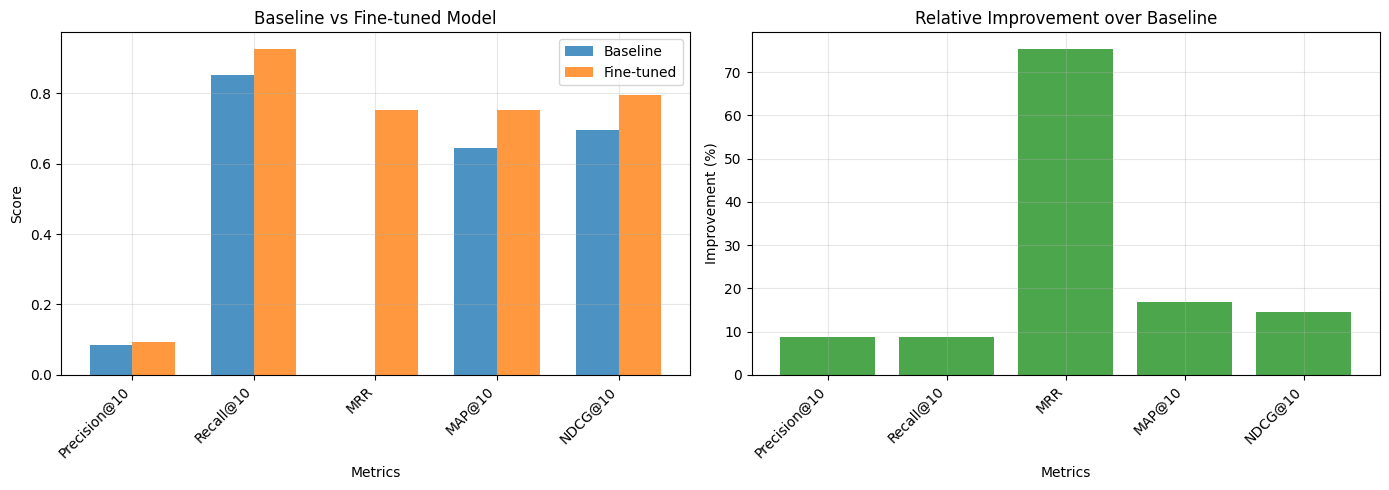


Improvement Summary
Precision@10.................. 0.0854 → 0.0929 (↑ 8.77%)
Recall@10..................... 0.8526 → 0.9271 (↑ 8.74%)
MRR........................... 0.0000 → 0.7541 (baseline was 0)
MAP@10........................ 0.6455 → 0.7538 (↑ 16.78%)
NDCG@10....................... 0.6958 → 0.7962 (↑ 14.42%)



In [39]:
# Compare with baseline (zero-shot only)
compare_with_baseline(test_metrics, baseline_results=baseline_results)

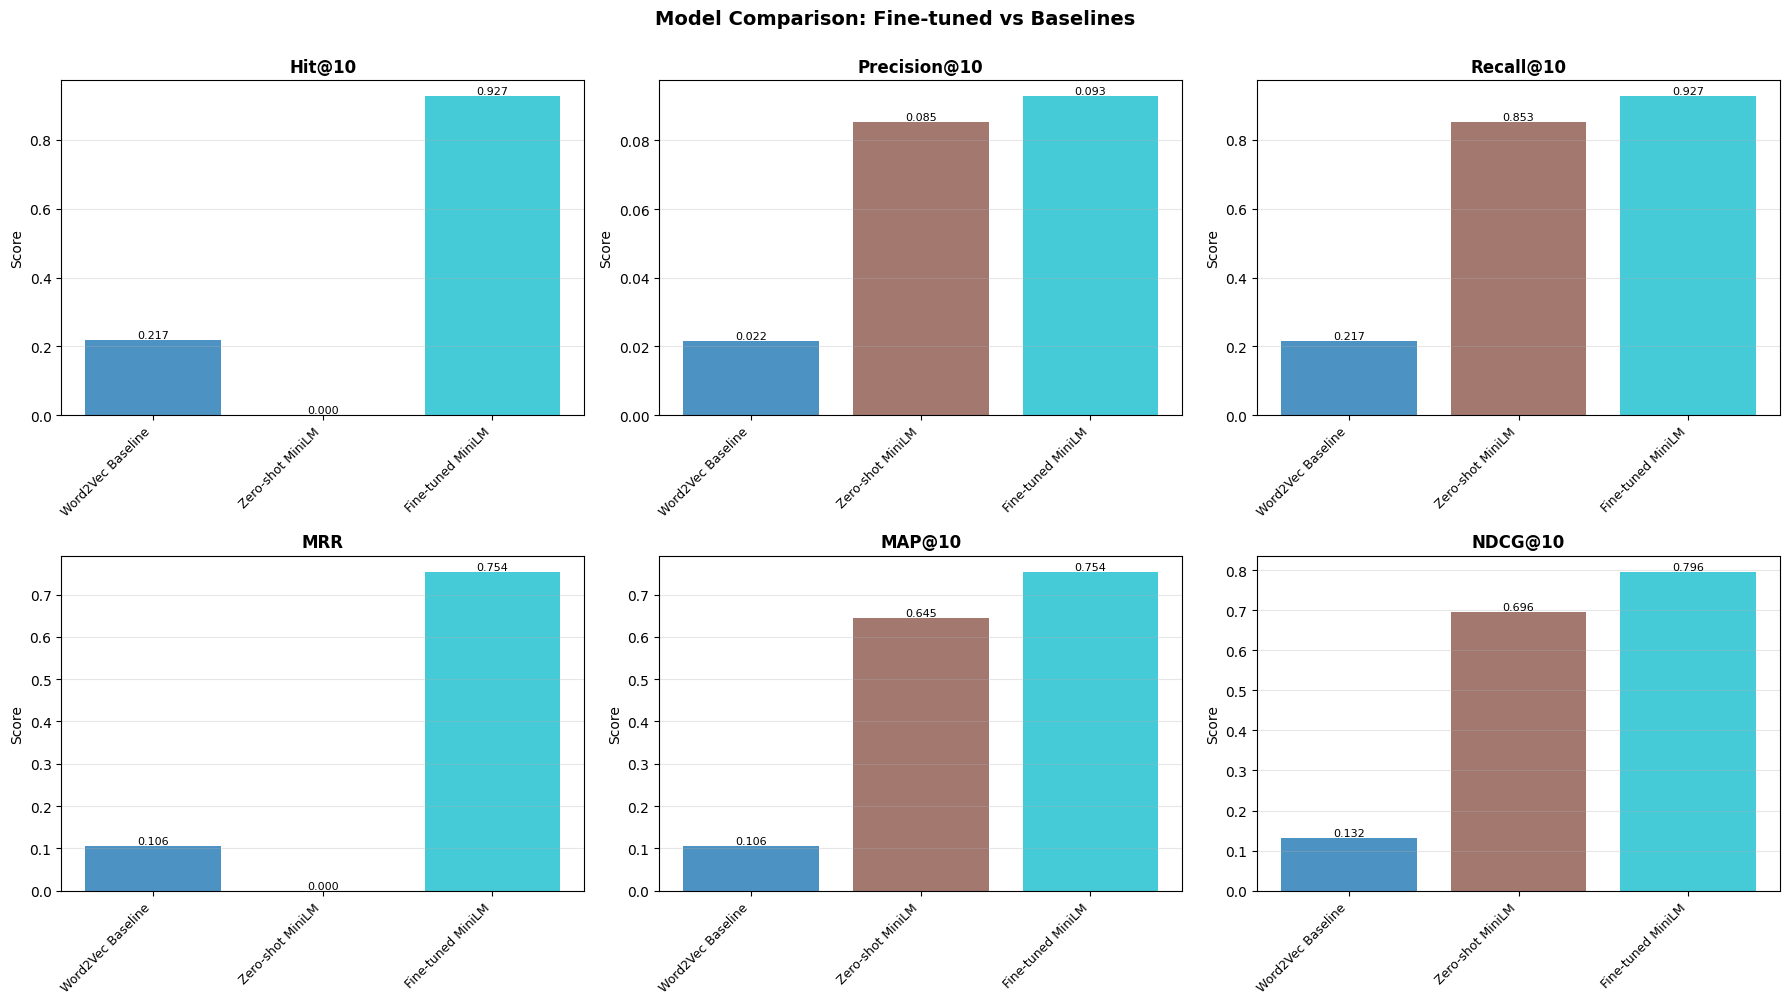


DETAILED MODEL COMPARISON

Model                          Hit@10Precision@10   Recall@10         MRR      MAP@10     NDCG@10
----------------------------------------------------------------------------------------------------
Word2Vec Baseline              0.2169      0.0217      0.2166      0.1057      0.1056      0.1317
Zero-shot MiniLM               0.0000      0.0854      0.8526      0.0000      0.6455      0.6958
Fine-tuned MiniLM              0.9271      0.0929      0.9271      0.7541      0.7538      0.7962



In [40]:
# Compare with all baseline models
logger.info("Generating comprehensive model comparison...")
compare_all_models(test_metrics, baseline_results, finetuned_name="Fine-tuned MiniLM")

### Analyze Individual Query Performance

Examine specific queries to understand model performance.


In [41]:
def analyze_query_performance(samples: List[Dict[str, Any]], num_examples: int = 5):
    """
    Analyze performance on individual queries

    Args:
        samples: Evaluation samples from evaluate_model_retrieval
        num_examples: Number of examples to display
    """
    # Calculate per-query metrics
    query_metrics = []

    for sample in samples:
        gt_set = set(str(x) for x in sample["ground_truth"])
        results = [str(x) for x in sample["contexts"]]

        # Hit@10
        hit = 1.0 if any(r in gt_set for r in results[:10]) else 0.0

        # Recall@10
        hits_count = sum(1 for r in results[:10] if r in gt_set)
        recall = hits_count / len(gt_set) if gt_set else 0.0

        # MRR
        mrr = 0.0
        for rank, r in enumerate(results, start=1):
            if r in gt_set:
                mrr = 1.0 / rank
                break

        query_metrics.append(
            {
                "query": sample["question"],
                "hit": hit,
                "recall": recall,
                "mrr": mrr,
                "num_relevant": len(gt_set),
                "retrieved": results[:10],
            }
        )

    # Sort by MRR (worst first)
    query_metrics.sort(key=lambda x: x["mrr"])

    print("\n" + "=" * 80)
    print(f"Worst {num_examples} Queries (by MRR)")
    print("=" * 80)

    for i, qm in enumerate(query_metrics[:num_examples], 1):
        print(f"\n{i}. Query: {qm['query'][:80]}...")
        print(
            f"   Hit@10: {qm['hit']:.0f} | Recall@10: {qm['recall']:.4f} | MRR: {qm['mrr']:.4f}"
        )
        print(f"   Relevant docs: {qm['num_relevant']}")

    print("\n" + "=" * 80)
    print(f"Best {num_examples} Queries (by MRR)")
    print("=" * 80)

    for i, qm in enumerate(query_metrics[-num_examples:][::-1], 1):
        print(f"\n{i}. Query: {qm['query'][:80]}...")
        print(
            f"   Hit@10: {qm['hit']:.0f} | Recall@10: {qm['recall']:.4f} | MRR: {qm['mrr']:.4f}"
        )
        print(f"   Relevant docs: {qm['num_relevant']}")

In [42]:
# Analyze query performance
analyze_query_performance(test_samples, num_examples=3)


Worst 3 Queries (by MRR)

1. Query: which pathogen controls cell division and neurulation in mice...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

2. Query: what is edu labeling?...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

3. Query: what is the role of the range range operon...
   Hit@10: 0 | Recall@10: 0.0000 | MRR: 0.0000
   Relevant docs: 1

Best 3 Queries (by MRR)

1. Query: metabolic remodeling in glioblastoma multiforme...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1

2. Query: why has the landscape of beijing changed...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1

3. Query: where does the mismatch argument arose...
   Hit@10: 1 | Recall@10: 1.0000 | MRR: 1.0000
   Relevant docs: 1


### Step 3: Evaluate Hard Negatives Model

In [43]:
# Evaluate the hard negatives model on test set
logger.info("=" * 70)
logger.info("Evaluating hard negatives model on test set")
logger.info("=" * 70)

test_metrics_hardneg, test_samples_hardneg = evaluate_model_retrieval(
    model=model_hardneg, data_dir=beir_dir, split="test", k=10
)

# Display results
display_evaluation_results(
    test_metrics_hardneg, title="Hard Negatives Model - Test Set Results"
)

  0%|          | 0/5183 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


               Hard Negatives Model - Test Set Results                

Retrieval Accuracy:
----------------------------------------------------------------------
  Hit@10.................................. 0.9294

Precision & Recall:
----------------------------------------------------------------------
  Precision@10............................ 0.0931
  Recall@10............................... 0.9294

Ranking Quality:
----------------------------------------------------------------------
  MRR..................................... 0.7597
  MAP@10.................................. 0.7595
  NDCG@10................................. 0.8011

Dataset Info:
----------------------------------------------------------------------
  N....................................... 3074



### Step 4: Compare All Models (Baseline + Standard Fine-tuning + Hard Negatives)

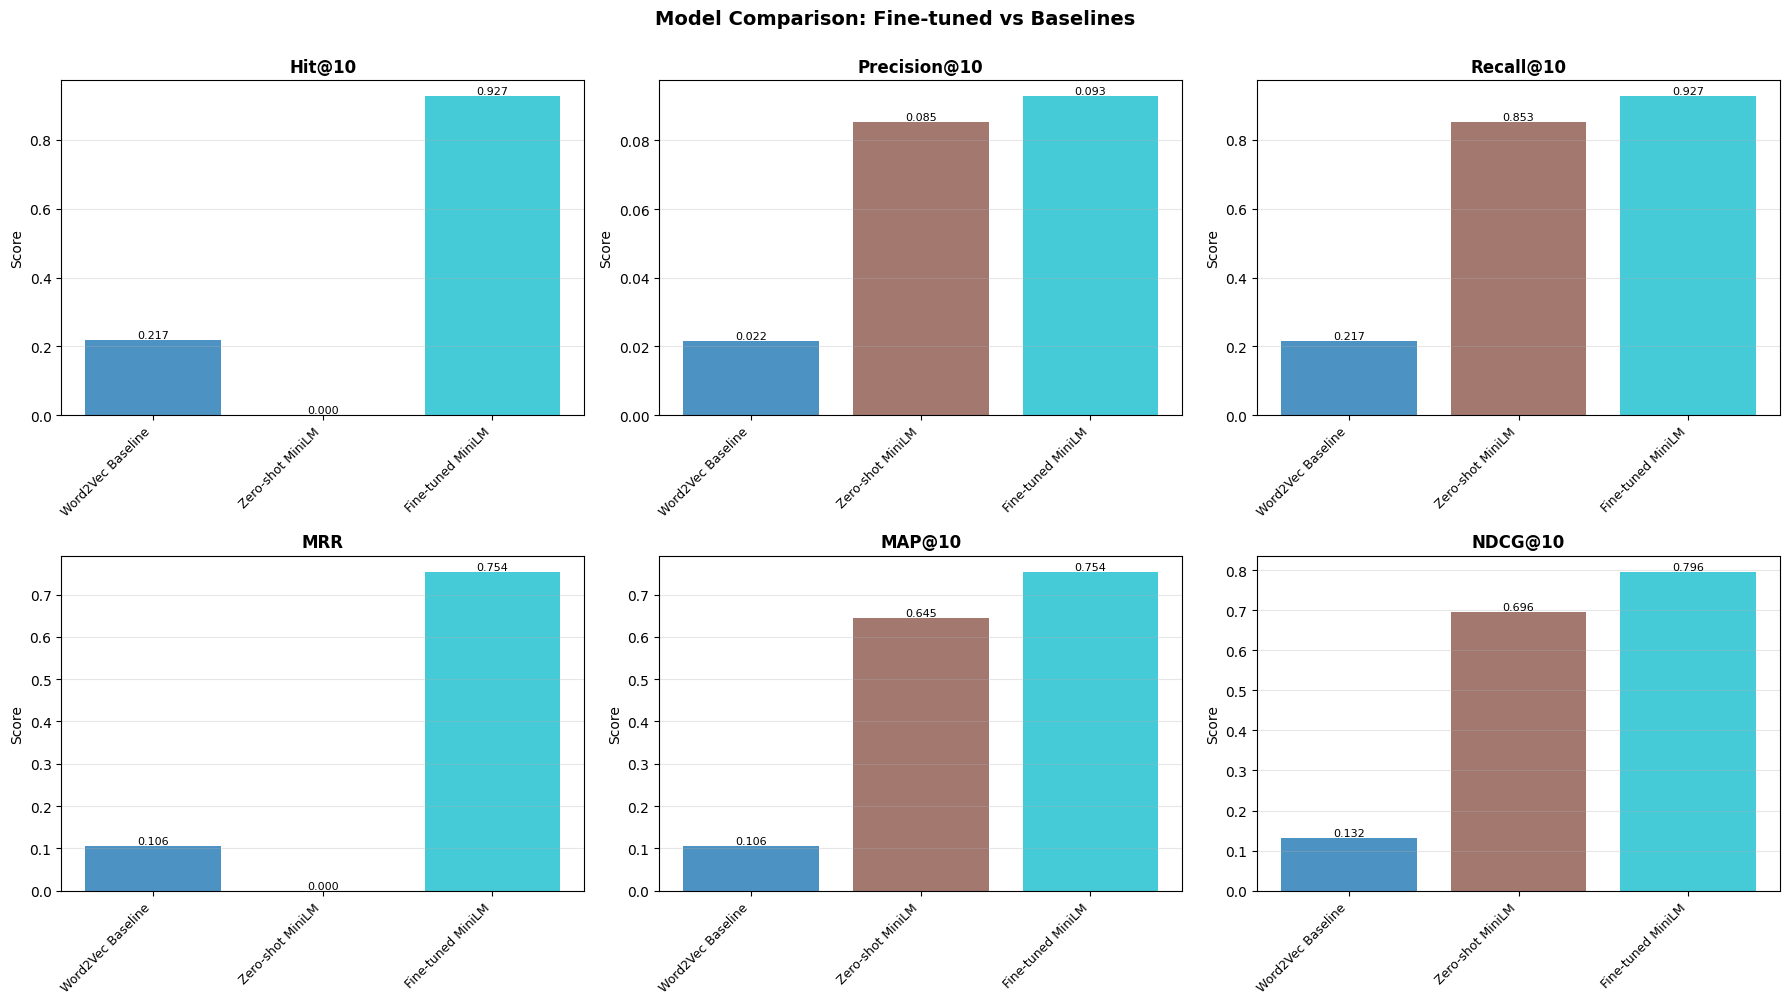


DETAILED MODEL COMPARISON

Model                          Hit@10Precision@10   Recall@10         MRR      MAP@10     NDCG@10
----------------------------------------------------------------------------------------------------
Word2Vec Baseline              0.2169      0.0217      0.2166      0.1057      0.1056      0.1317
Zero-shot MiniLM               0.0000      0.0854      0.8526      0.0000      0.6455      0.6958
Fine-tuned MiniLM              0.9271      0.0929      0.9271      0.7541      0.7538      0.7962



In [44]:
# Compare all three approaches
logger.info(
    "Generating comprehensive comparison: Baseline vs Fine-tuned vs Hard Negatives..."
)

# Prepare data for comparison
all_models_results = baseline_results.copy()

# Add standard fine-tuned model
all_models_results["Fine-tuned (Standard MNRL)"] = {
    "metrics": test_metrics,
    "model_type": "Fine-tuned",
    "base_model": MODEL_NAME,
}

# Add hard negatives model
all_models_results["Fine-tuned (Hard Negatives)"] = {
    "metrics": test_metrics_hardneg,
    "model_type": "Fine-tuned with Hard Negatives",
    "base_model": MODEL_NAME_HARDNEG,
}

# Display comprehensive comparison
compare_all_models(test_metrics, baseline_results, finetuned_name="Fine-tuned MiniLM")

### Detailed Comparison: Standard vs Hard Negatives Fine-tuning

In [45]:
def compare_finetuning_methods(
    standard_metrics: Dict[str, float],
    hardneg_metrics: Dict[str, float],
):
    """
    Compare standard fine-tuning vs hard negatives fine-tuning
    """
    import matplotlib.pyplot as plt

    metric_names = ["Hit@10", "Precision@10", "Recall@10", "MRR", "MAP@10", "NDCG@10"]

    standard_values = []
    hardneg_values = []
    display_names = []

    for metric in metric_names:
        if metric in standard_metrics and metric in hardneg_metrics:
            standard_values.append(standard_metrics[metric])
            hardneg_values.append(hardneg_metrics[metric])
            display_names.append(metric)

    if not display_names:
        logger.warning("No common metrics found for comparison")
        return

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart comparison
    x = range(len(display_names))
    width = 0.35

    ax1.bar(
        [i - width / 2 for i in x],
        standard_values,
        width,
        label="Standard MNRL",
        alpha=0.8,
        color="steelblue",
    )
    ax1.bar(
        [i + width / 2 for i in x],
        hardneg_values,
        width,
        label="Hard Negatives",
        alpha=0.8,
        color="orange",
    )
    ax1.set_xlabel("Metrics")
    ax1.set_ylabel("Score")
    ax1.set_title("Standard Fine-tuning vs Hard Negatives Fine-tuning")
    ax1.set_xticks(x)
    ax1.set_xticklabels(display_names, rotation=45, ha="right")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Improvement percentage
    improvements = [
        (h - s) / s * 100 if s > 0 else 0
        for s, h in zip(standard_values, hardneg_values)
    ]

    colors = ["green" if imp > 0 else "red" for imp in improvements]

    ax2.bar(x, improvements, color=colors, alpha=0.7)
    ax2.set_xlabel("Metrics")
    ax2.set_ylabel("Improvement (%)")
    ax2.set_title("Hard Negatives Improvement over Standard Fine-tuning")
    ax2.set_xticks(x)
    ax2.set_xticklabels(display_names, rotation=45, ha="right")
    ax2.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print("\n" + "=" * 80)
    print("Fine-tuning Methods Comparison")
    print("=" * 80)
    print(
        f"\n{'Metric':<20} {'Standard MNRL':>15} {'Hard Negatives':>15} {'Improvement':>15}"
    )
    print("-" * 80)

    for name, std_val, hn_val, imp in zip(
        display_names, standard_values, hardneg_values, improvements
    ):
        arrow = "↑" if imp > 0 else "↓"
        print(
            f"{name:<20} {std_val:>15.4f} {hn_val:>15.4f} {arrow:>2} {abs(imp):>12.2f}%"
        )

    print("=" * 80 + "\n")

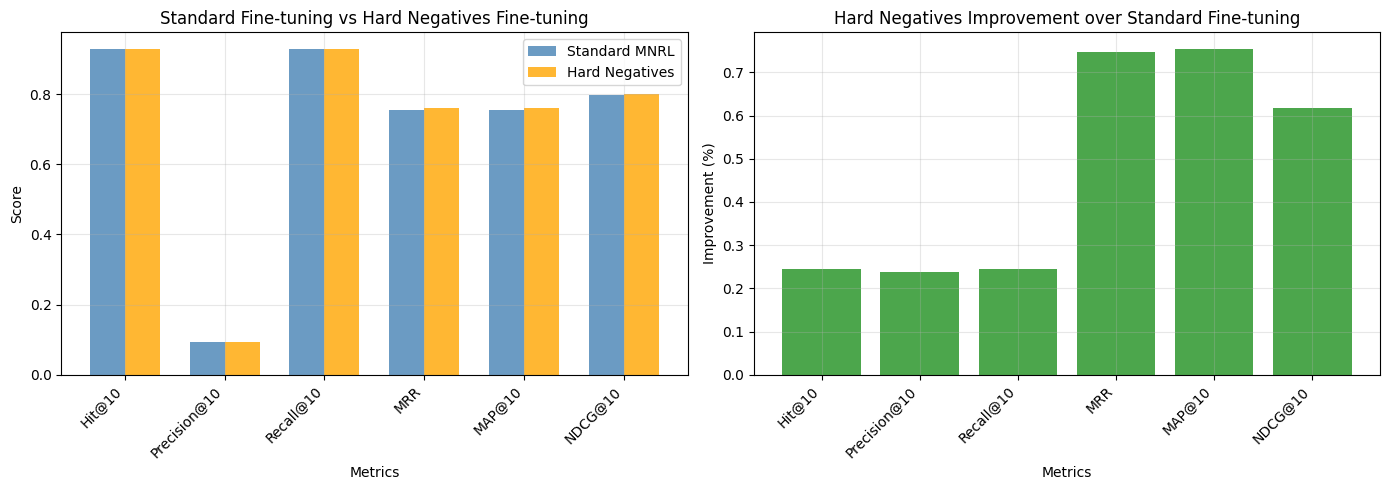


Fine-tuning Methods Comparison

Metric                 Standard MNRL  Hard Negatives     Improvement
--------------------------------------------------------------------------------
Hit@10                        0.9271          0.9294  ↑         0.25%
Precision@10                  0.0929          0.0931  ↑         0.24%
Recall@10                     0.9271          0.9294  ↑         0.25%
MRR                           0.7541          0.7597  ↑         0.75%
MAP@10                        0.7538          0.7595  ↑         0.75%
NDCG@10                       0.7962          0.8011  ↑         0.62%



In [46]:
# Compare the two fine-tuning approaches
compare_finetuning_methods(test_metrics, test_metrics_hardneg)

## 8. Results Visualization

Visualize training results and evaluation metrics.

In [47]:
# Configure matplotlib for notebook display
import matplotlib.pyplot as plt
import matplotlib

# For Jupyter/IPython environments
try:
    from IPython.core.getipython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        ipython.run_line_magic("matplotlib", "inline")
except Exception:
    pass

# Set default style
plt.style.use("default")
matplotlib.rcParams["figure.dpi"] = 100

In [48]:
def plot_evaluation_results(results_csv_path: str):
    """
    Plot evaluation results

    Args:
        results_csv_path: Path to the evaluation results CSV file
    """
    import matplotlib.pyplot as plt

    if not Path(results_csv_path).exists():
        logger.warning(f"Results file not found: {results_csv_path}")
        print(f"File not found: {results_csv_path}")
        print(
            f"Please make sure the model has been trained and evaluation results exist."
        )
        return

    # Read results
    df = pd.read_csv(results_csv_path)
    # take the last evaluation result of this epoch
    df["epoch"] = pd.to_numeric(df["epoch"], errors="coerce")
    df = df.dropna(subset=["epoch"])

    if df["epoch"].duplicated().any():
        if "steps" in df.columns:
            df["steps"] = pd.to_numeric(df["steps"], errors="coerce").fillna(-1)
            df = (
                df.sort_values(["epoch", "steps"])
                .groupby("epoch", as_index=False)
                .last()
            )
        else:
            df = df.groupby("epoch", as_index=False).last()

    print(f"Loaded results with {len(df)} rows")
    print(f"Available columns: {df.columns.tolist()}")

    # Define metrics to plot (try both naming conventions)
    # sentence-transformers uses format: "cosine-NDCG@10"
    # Alternative format: "ndcg_at_10"
    # metric_mappings = {
    #     "NDCG@10": ["cosine-NDCG@10", "ndcg_at_10"],
    #     "MAP@100": ["cosine-MAP@100", "map_at_100"],
    #     "Recall@10": ["cosine-Recall@10", "recall_at_10"],
    #     "Precision@10": ["cosine-Precision@10", "precision_at_10"],
    # }
    metric_mappings = {
        "NDCG@10": "cosine-NDCG@10",
        "MAP@100": "cosine-MAP@100",
        "Recall@10": "cosine-Recall@10",
        "Precision@10": "cosine-Precision@10",
    }

    # Find which metrics are available
    available_metrics = {k: v for k, v in metric_mappings.items() if v in df.columns}

    if not available_metrics:
        print("Warning: cosine metrics not found in CSV")
        print(f"Available columns: {df.columns.tolist()}")
        return

    print(f"\nPlotting metrics: {list(available_metrics.keys())}")

    # Create subplots
    n_metrics = len(available_metrics)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (display_name, col_name) in enumerate(available_metrics.items()):
        ax = axes[i]
        ax.plot(
            df["epoch"],
            df[col_name],
            marker="o",
            linewidth=2,
            markersize=6,
            color="steelblue",
        )
        ax.set_title(display_name, fontsize=12, fontweight="bold")
        ax.set_xlabel("Epoch", fontsize=10)
        ax.set_ylabel("Score", fontsize=10)
        ax.grid(True, alpha=0.3, linestyle="--")

        # Add value annotations on points (only if not too many points)
        if len(df) <= 20:
            for x, y in zip(df["epoch"], df[col_name]):
                ax.annotate(
                    f"{y:.3f}",
                    (x, y),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha="center",
                    fontsize=7,
                    alpha=0.7,
                )

    # Hide unused subplots
    for i in range(n_metrics, 4):
        axes[i].set_visible(False)

    plt.suptitle("Training Evaluation Results", fontsize=14, fontweight="bold", y=1.00)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    df = df.sort_values("epoch").reset_index(drop=True)
    print("\n" + "=" * 70)
    print("Evaluation Results Summary")
    print("=" * 70)
    for display_name, col_name in available_metrics.items():
        best_idx = df[col_name].idxmax()
        best_epoch = df.loc[best_idx, "epoch"]
        best_score = df[col_name].max()
        final_score = df[col_name].iloc[-1]
        print(f"{display_name}:")
        print(f"  Best:  {best_score:.4f} (epoch {int(best_epoch)})")
        print(f"  Final: {final_score:.4f}")
        base = df[col_name].iloc[0]
        improve = ((final_score - base) / base * 100) if base != 0 else float("nan")
        print(f"  Improvement: {improve:.2f}%")
        print("=" * 70)
    print("=" * 60)

Loaded results with 6 rows
Available columns: ['epoch', 'steps', 'cosine-Accuracy@1', 'cosine-Accuracy@3', 'cosine-Accuracy@5', 'cosine-Accuracy@10', 'cosine-Precision@10', 'cosine-Recall@10', 'cosine-Precision@100', 'cosine-Recall@100', 'cosine-MRR@10', 'cosine-NDCG@10', 'cosine-NDCG@100', 'cosine-MAP@100']

Plotting metrics: ['NDCG@10', 'MAP@100', 'Recall@10', 'Precision@10']


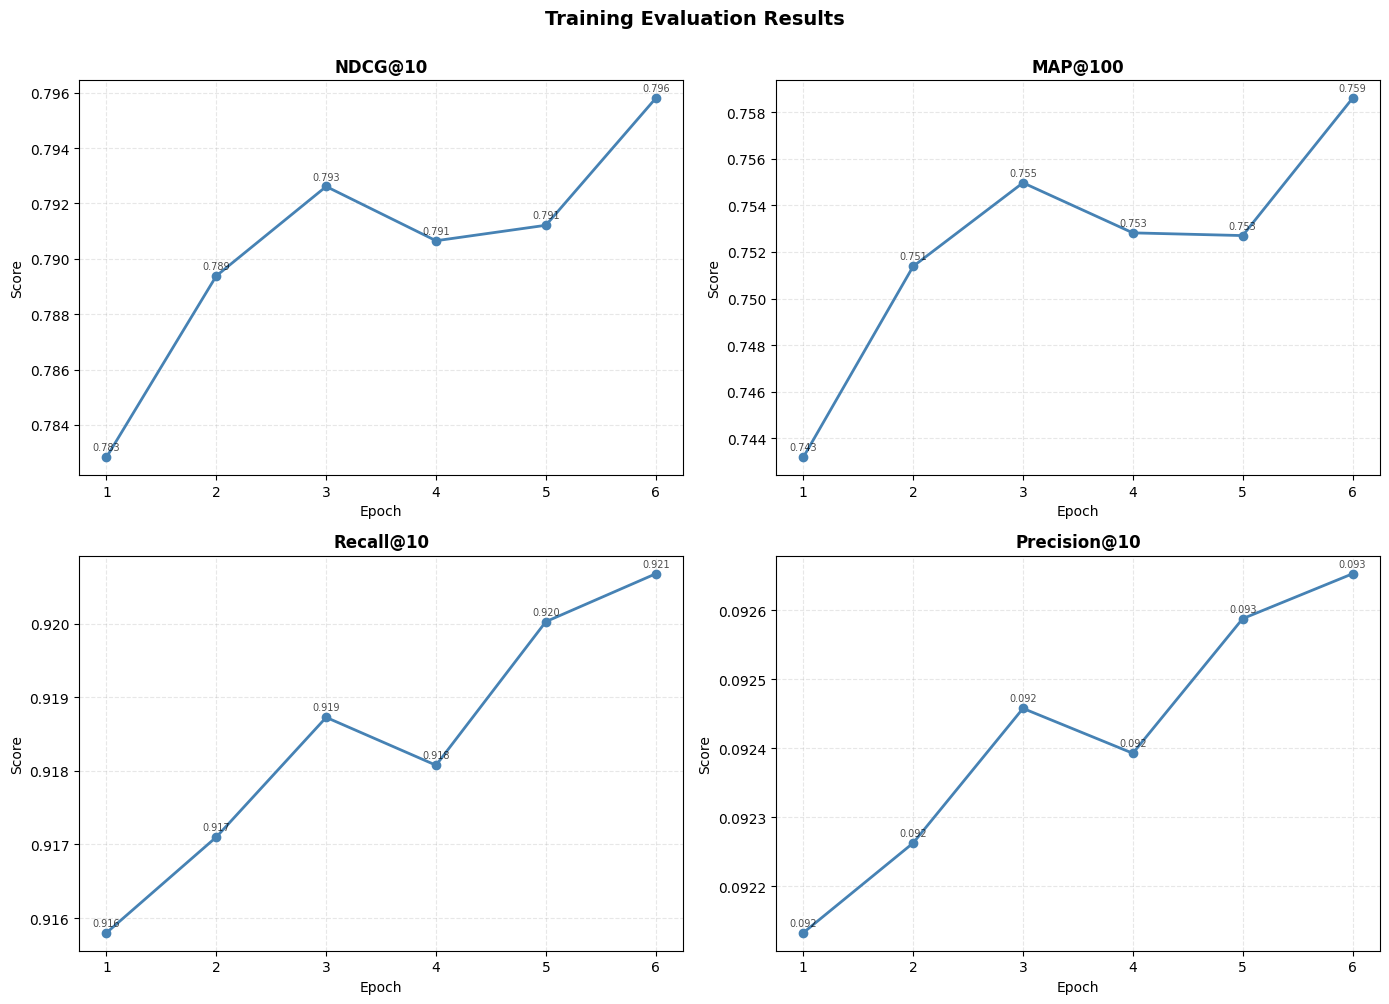


Evaluation Results Summary
NDCG@10:
  Best:  0.7958 (epoch 6)
  Final: 0.7958
  Improvement: 1.66%
MAP@100:
  Best:  0.7586 (epoch 6)
  Final: 0.7586
  Improvement: 2.07%
Recall@10:
  Best:  0.9207 (epoch 6)
  Final: 0.9207
  Improvement: 0.53%
Precision@10:
  Best:  0.0927 (epoch 6)
  Final: 0.0927
  Improvement: 0.56%


In [49]:
# Visualize results (if training logs exist)
# Uncomment the lines below after training is complete
results_path = f"{OUTPUT_DIR}/eval/Information-Retrieval_evaluation_dev_results.csv"
plot_evaluation_results(results_path)

### Visualize Hard Negatives Training Results

Loaded results with 4 rows
Available columns: ['epoch', 'steps', 'cosine-Accuracy@1', 'cosine-Accuracy@3', 'cosine-Accuracy@5', 'cosine-Accuracy@10', 'cosine-Precision@10', 'cosine-Recall@10', 'cosine-Precision@100', 'cosine-Recall@100', 'cosine-MRR@10', 'cosine-NDCG@10', 'cosine-NDCG@100', 'cosine-MAP@100']

Plotting metrics: ['NDCG@10', 'MAP@100', 'Recall@10', 'Precision@10']


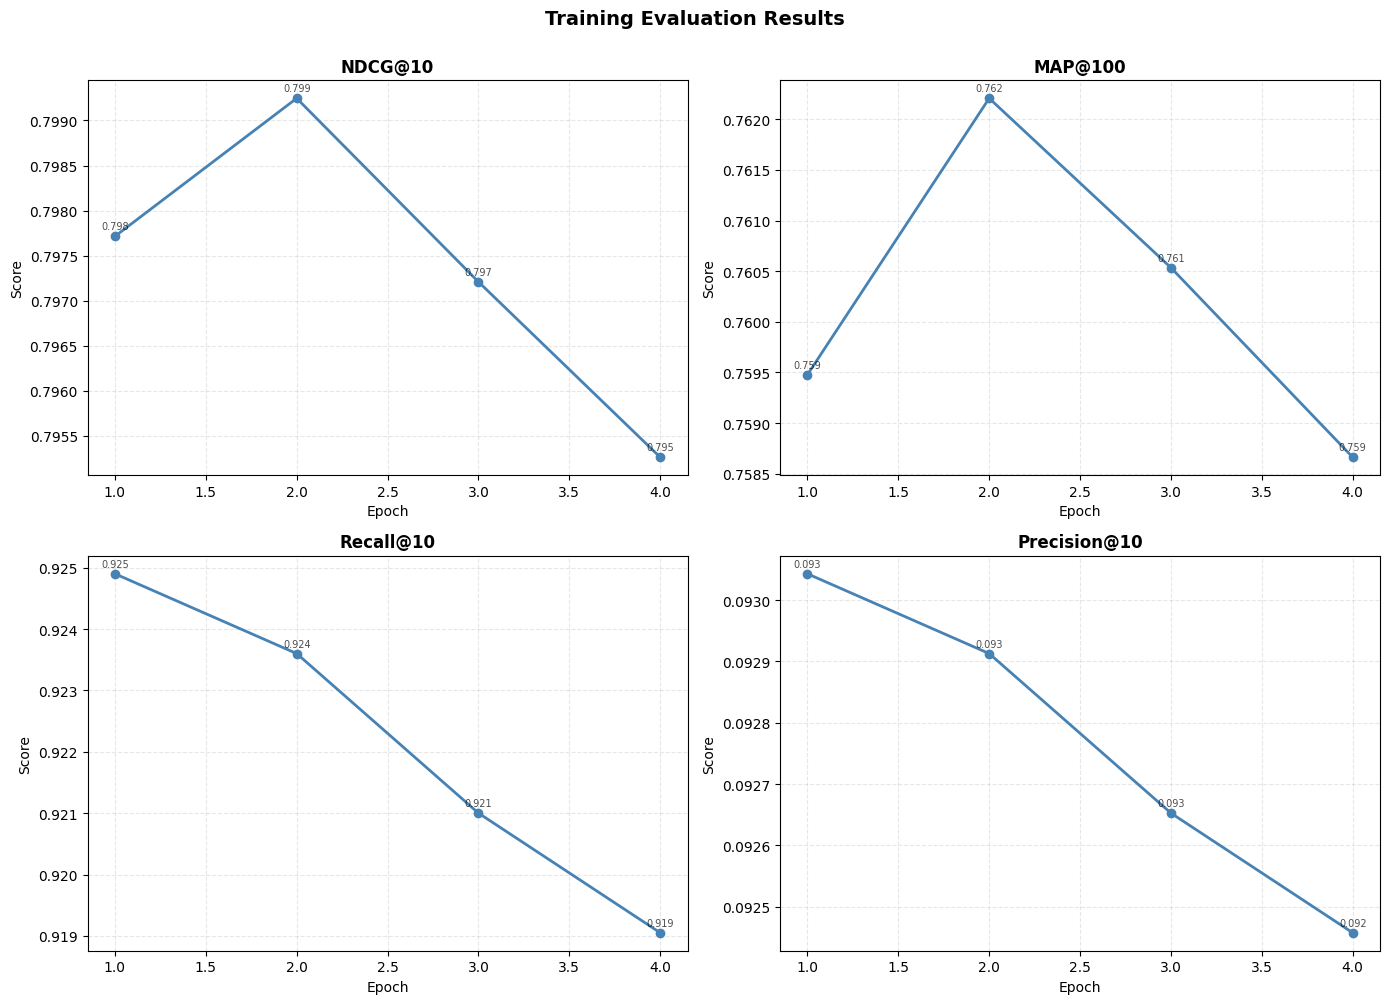


Evaluation Results Summary
NDCG@10:
  Best:  0.7992 (epoch 2)
  Final: 0.7953
  Improvement: -0.31%
MAP@100:
  Best:  0.7622 (epoch 2)
  Final: 0.7587
  Improvement: -0.11%
Recall@10:
  Best:  0.9249 (epoch 1)
  Final: 0.9191
  Improvement: -0.63%
Precision@10:
  Best:  0.0930 (epoch 1)
  Final: 0.0925
  Improvement: -0.63%


In [50]:
# Visualize hard negatives training results
results_path_hardneg = (
    f"{OUTPUT_DIR_HARDNEG}/eval/Information-Retrieval_evaluation_dev_results.csv"
)
plot_evaluation_results(results_path_hardneg)

# 9. Analysis

## 9.1 Overall Performance Overview

To facilitate a comprehensive comparison across all retrieval approaches, we first present an overall performance overview of all evaluated models.

Table X summarizes the retrieval results of four representative methods:
- **Word2Vec Baseline** (classical word-embedding baseline)
- **Zero-shot MiniLM** (pretrained sentence embedding model without task-specific training)
- **Fine-tuned MiniLM (Standard MNRL)** (task-specific contrastive fine-tuning)
- **Fine-tuned MiniLM (Hard Negatives)** (contrastive fine-tuning with harder negative samples)

All models are evaluated on the same BEIR-formatted **test split** using the same evaluation protocol. We report standard retrieval and ranking metrics including **NDCG@{10,100}**, **MAP@{10,100}**, **Recall@{10,100}**, **Precision@{10,100}**, **Hit@10**, and **MRR**, with **N** denoting the number of test queries.

This unified comparison provides a high-level view of how increasingly sophisticated modeling and training strategies affect retrieval quality, and serves as the basis for the detailed analysis in the following sections.

In [66]:
import pandas as pd

# Metrics schema (consistent with your zeroshot_metrics)
METRICS = [
    "NDCG@10", "NDCG@100",
    "MAP@10", "MAP@100",
    "Recall@10", "Recall@100",
    "Precision@10", "Precision@100",
    "Hit@10",
    "MRR",
    "N",
]

def normalize_metrics(m: dict) -> dict:
    """
    Normalize possible naming differences across sources.
    (e.g., BEIR sometimes uses P@10/P@100 for precision.)
    """
    return {
        "NDCG@10": m.get("NDCG@10"),
        "NDCG@100": m.get("NDCG@100"),
        "MAP@10": m.get("MAP@10"),
        "MAP@100": m.get("MAP@100"),
        "Recall@10": m.get("Recall@10"),
        "Recall@100": m.get("Recall@100"),
        "Precision@10": m.get("Precision@10", m.get("P@10")),
        "Precision@100": m.get("Precision@100", m.get("P@100")),
        "Hit@10": m.get("Hit@10"),
        "MRR": m.get("MRR", m.get("MRR@10", m.get("mrr@10"))),
        "N": m.get("N"),
    }

rows = []

# A) Word2Vec Baseline from baseline_results (already loaded)
# If baseline_results includes multiple baselines, we select the Word2Vec one(s).
for name, info in baseline_results.items():
    if "word2vec" in name.lower():
        rows.append({"Model": name, **normalize_metrics(info.get("metrics", {}))})

# B) Zero-shot MiniLM (use existing variable, do NOT recompute)
rows.append({"Model": "Zero-shot MiniLM", **normalize_metrics(zeroshot_metrics)})

# C) Fine-tuned models (already computed earlier in notebook)
rows.append({"Model": "Fine-tuned (Standard MNRL)", **normalize_metrics(test_metrics)})
rows.append({"Model": "Fine-tuned (Hard Negatives)", **normalize_metrics(test_metrics_hardneg)})

df_all = pd.DataFrame(rows)

# Ensure all metric columns exist + numeric conversion
for col in METRICS:
    if col not in df_all.columns:
        df_all[col] = pd.NA
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

# Reorder columns: Model first, then metrics
df_all = df_all[["Model"] + METRICS]

df_all

,Model,NDCG@10,NDCG@100,MAP@10,MAP@100,Recall@10,Recall@100,Precision@10,Precision@100,Hit@10,MRR,N
0,Word2Vec Baseline,0.13258,0.19071,0.10578,0.11600,0.22023,0.51171,0.02206,0.00512,0.220560,0.105939,3074.0
1,Zero-shot MiniLM,0.69584,0.72150,0.64550,0.65117,0.85264,0.96861,0.08539,0.00970,0.852960,0.645748,3074.0
2,Fine-tuned (Standard MNRL),0.79621,0.80900,0.75384,0.75668,0.92713,0.98471,0.09288,0.00986,0.927131,0.754105,3074.0
3,Fine-tuned (Hard Negatives),0.80113,0.81405,0.75953,0.76232,0.92941,0.98829,0.09310,0.00990,0.929408,0.759740,3074.0


In [67]:
out_csv = RESULTS_DIR / "all_models_metrics_summary.csv"
df_all.to_csv(out_csv, index=False)

print("Saved and overwritten:", out_csv)

Saved and overwritten: /content/drive/MyDrive/semantic-retrieval/results/all_models_metrics_summary.csv


## 9.2 Baseline Comparison: Word2Vec vs Neural Embeddings

We begin our analysis by comparing the classical **Word2Vec baseline** with neural sentence embedding models. As shown in Table X, the Word2Vec retriever performs substantially worse across all evaluation metrics, including NDCG, MAP, Recall, Precision, Hit@10, and MRR.

In particular, the gap is most pronounced for **ranking-sensitive metrics** such as NDCG@10, MAP@10, and MRR. This indicates that Word2Vec not only retrieves fewer relevant documents, but also struggles to rank relevant documents near the top of the result list.

### Why does Word2Vec perform poorly?

The low performance of Word2Vec can be attributed to several fundamental limitations:

**(1) Lack of contextual representation.**  
Word2Vec assigns a single static embedding to each word, regardless of its context. Sentence representations are obtained by simple averaging of word embeddings, which fails to capture compositional semantics and word order. As a result, queries and documents that are semantically related but lexically different are often mapped far apart in the embedding space.

**(2) No task-specific supervision.**  
The Word2Vec model is trained using a generic distributional objective and is not optimized for the retrieval task. It does not learn to distinguish relevant documents from non-relevant ones for a given query, which directly limits its effectiveness for semantic search.

**(3) Weak query–document interaction modeling.**  
By representing both queries and documents as averaged word vectors, Word2Vec lacks an explicit mechanism to align query intent with document content. This leads to poor discrimination between truly relevant documents and superficially similar but irrelevant ones.

These limitations collectively explain the extremely low precision and ranking quality observed for the Word2Vec baseline. While Word2Vec provides a useful lower bound for performance, it is fundamentally insufficient for high-quality semantic retrieval.

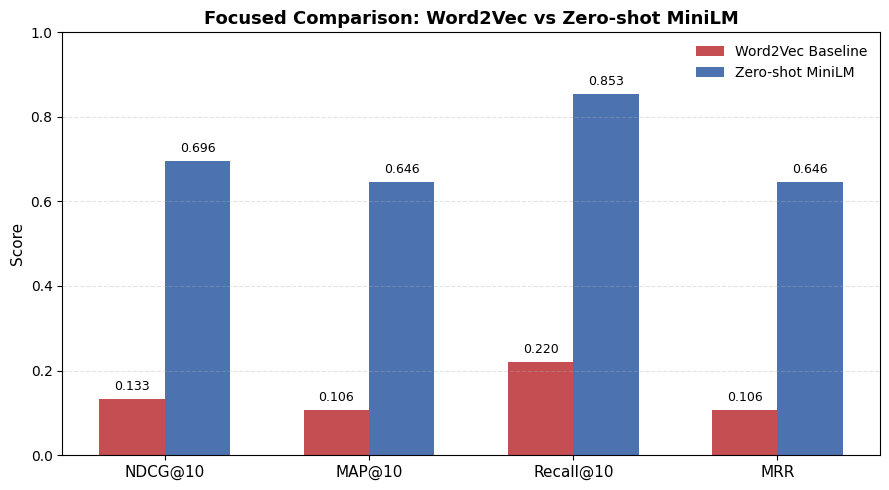

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Focused comparison data (from computed results)
data = [
    {
        "Model": "Word2Vec Baseline",
        "NDCG@10": 0.133,
        "MAP@10": 0.106,
        "Recall@10": 0.220,
        "MRR": 0.106,
    },
    {
        "Model": "Zero-shot MiniLM",
        "NDCG@10": 0.696,
        "MAP@10": 0.646,
        "Recall@10": 0.853,
        "MRR": 0.646,
    },
]

df_focus = pd.DataFrame(data)

metrics = ["NDCG@10", "MAP@10", "Recall@10", "MRR"]
x = np.arange(len(metrics))
width = 0.32

w2v_values = df_focus[df_focus["Model"] == "Word2Vec Baseline"][metrics].values.flatten()
zero_values = df_focus[df_focus["Model"] == "Zero-shot MiniLM"][metrics].values.flatten()

# ---- Plot ----
plt.figure(figsize=(9, 5))

bars_w2v = plt.bar(
    x - width / 2,
    w2v_values,
    width,
    label="Word2Vec Baseline",
    color="#C44E52",   # muted red (weak baseline)
)

bars_zero = plt.bar(
    x + width / 2,
    zero_values,
    width,
    label="Zero-shot MiniLM",
    color="#4C72B0",   # muted blue (neural baseline)
)

# ---- Styling ----
plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Score", fontsize=11)
plt.title(
    "Focused Comparison: Word2Vec vs Zero-shot MiniLM",
    fontsize=13,
    fontweight="bold",
)
plt.ylim(0, 1.0)

plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)

# ---- Value labels ----
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

add_value_labels(bars_w2v)
add_value_labels(bars_zero)

plt.tight_layout()
plt.show()

## 9.3 Zero-shot vs Fine-tuned MiniLM

After establishing the limitations of classical word-based representations, we next analyze the impact of **task-specific fine-tuning** by comparing the zero-shot MiniLM model with its fine-tuned counterparts.

As shown in Table X, the zero-shot MiniLM model already achieves strong performance across all metrics, substantially outperforming the Word2Vec baseline. This indicates that pretrained sentence embedding models capture a significant amount of semantic information even without exposure to task-specific supervision.

However, fine-tuning the MiniLM model using Multiple Negatives Ranking Loss (MNRL) leads to **consistent and substantial improvements** across all ranking and retrieval metrics. Notably, metrics that emphasize ranking quality, such as **NDCG@10**, **MAP@10**, and **MRR**, exhibit clear gains after fine-tuning. This suggests that fine-tuning helps align the embedding space more closely with the retrieval objective.

The observed improvements can be attributed to the contrastive training objective, which explicitly optimizes the relative distances between queries and relevant versus non-relevant documents. Unlike the zero-shot setting, fine-tuning encourages the model to learn task-specific notions of relevance, resulting in more discriminative representations and improved retrieval performance.

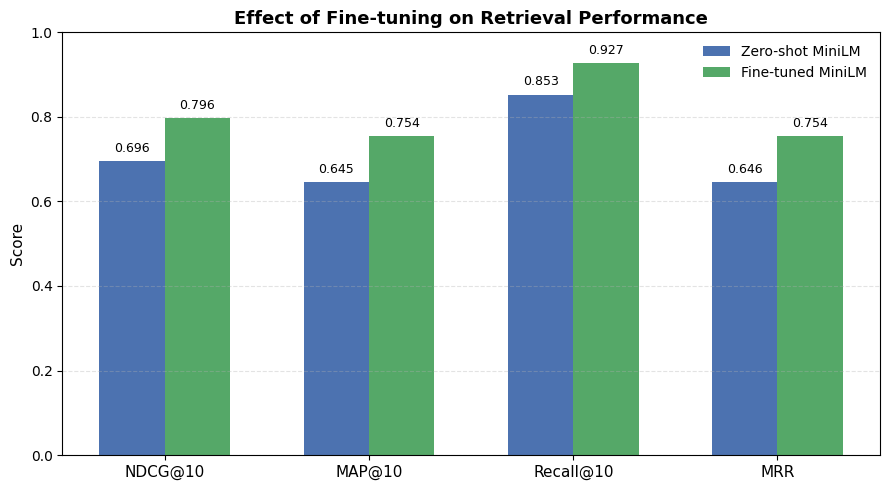

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data from evaluated results (do NOT recompute models here)
plot_data = [
    {
        "Model": "Zero-shot MiniLM",
        "NDCG@10": 0.69584,
        "MAP@10": 0.64550,
        "Recall@10": 0.85264,
        "MRR": 0.64575,
    },
    {
        "Model": "Fine-tuned (Standard MNRL)",
        "NDCG@10": 0.79621,
        "MAP@10": 0.75384,
        "Recall@10": 0.92713,
        "MRR": 0.75411,
    },
]

df_plot = pd.DataFrame(plot_data)

metrics = ["NDCG@10", "MAP@10", "Recall@10", "MRR"]
x = np.arange(len(metrics))
width = 0.32

zero_vals = df_plot[df_plot["Model"] == "Zero-shot MiniLM"][metrics].values.flatten()
ft_vals = df_plot[df_plot["Model"].str.contains("Fine-tuned")][metrics].values.flatten()

# ---- Plot ----
plt.figure(figsize=(9, 5))

bars_zero = plt.bar(
    x - width / 2,
    zero_vals,
    width,
    label="Zero-shot MiniLM",
    color="#4C72B0",   # muted blue
)

bars_ft = plt.bar(
    x + width / 2,
    ft_vals,
    width,
    label="Fine-tuned MiniLM",
    color="#55A868",   # muted green
)

# ---- Styling ----
plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Score", fontsize=11)
plt.title(
    "Effect of Fine-tuning on Retrieval Performance",
    fontsize=13,
    fontweight="bold",
)
plt.ylim(0, 1.0)

plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)

# ---- Value labels ----
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.015,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

add_value_labels(bars_zero)
add_value_labels(bars_ft)

plt.tight_layout()
plt.show()

## 9.4 Impact of Hard Negatives

In this section, we analyze the effect of incorporating hard negatives during fine-tuning.
We combine quantitative visualization with conceptual analysis to better understand why hard negatives lead to consistent, though modest, performance gains.


9.4.1 Quantitative Comparison

We compare two fine-tuned models:
	•	Fine-tuned (Standard MNRL)
	•	Fine-tuned (Hard Negatives)

Both models are evaluated on the same test split using identical evaluation metrics.

The goal is to isolate the effect of hard negatives while keeping all other factors fixed.

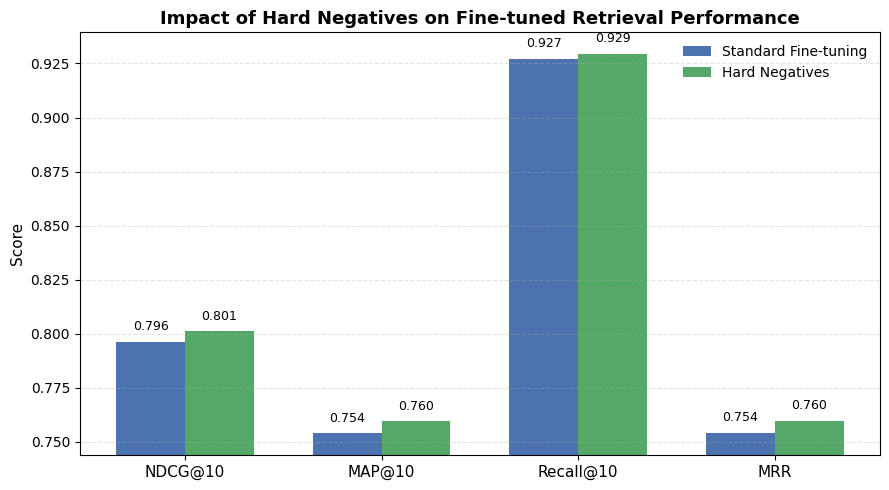

In [86]:
all_vals = np.concatenate([std_vals, hn_vals])
y_min = all_vals.min() - 0.01
y_max = all_vals.max() + 0.01

plt.figure(figsize=(9, 5))

bars_std = plt.bar(
    x - width / 2,
    std_vals,
    width,
    label="Standard Fine-tuning",
    color="#4C72B0",
)

bars_hn = plt.bar(
    x + width / 2,
    hn_vals,
    width,
    label="Hard Negatives",
    color="#55A868",
)

plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Score", fontsize=11)
plt.title(
    "Impact of Hard Negatives on Fine-tuned Retrieval Performance",
    fontsize=13,
    fontweight="bold",
)

plt.ylim(y_min, y_max)

plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)

def add_labels(bars):
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h + (y_max - y_min) * 0.02,
            f"{h:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

add_labels(bars_std)
add_labels(bars_hn)

plt.tight_layout()
plt.show()



9.4.2 Interpretation of the Results

From the figure above, we observe that the model trained with hard negatives consistently outperforms the standard fine-tuned model across all reported metrics.

Although the absolute improvements are relatively small, two important patterns emerge:
	•	The improvements are uniform across metrics, including ranking quality (NDCG@10, MAP@10) and early retrieval accuracy (MRR).
	•	No metric shows degradation, indicating that hard negatives improve overall ranking behavior rather than over-optimizing a specific metric.

This consistency suggests that the gains are systematic rather than due to random variation.

9.4.3 Why Hard Negatives Help

The observed improvements can be explained by the role of hard negatives in contrastive learning.

Hard negatives are semantically similar to the query but are not relevant. As a result, they lie closer to the model’s decision boundary in the embedding space.

Training with such negatives forces the model to:
	•	Learn finer-grained semantic distinctions,
	•	Reduce ambiguity between closely related documents,
	•	Improve the relative ordering of top-ranked results.

This effect is particularly visible in MRR, which reflects early ranking quality.

## 9.5 Metric-wise Discussion

To further understand how different training strategies affect retrieval behavior, we analyze performance metric by metric.
Rather than focusing solely on overall scores, this section examines which aspects of retrieval improve the most and why.

We consider the following representative metrics:
	•	Recall@10 – retrieval coverage
	•	NDCG@10 / MAP@10 – ranking quality
	•	MRR – early ranking accuracy
	•	Precision@10 – precision at fixed cutoff

9.5.1 Absolute Metric Comparison Across Models

The following figure compares absolute metric values across all models, providing a high-level overview of performance differences.


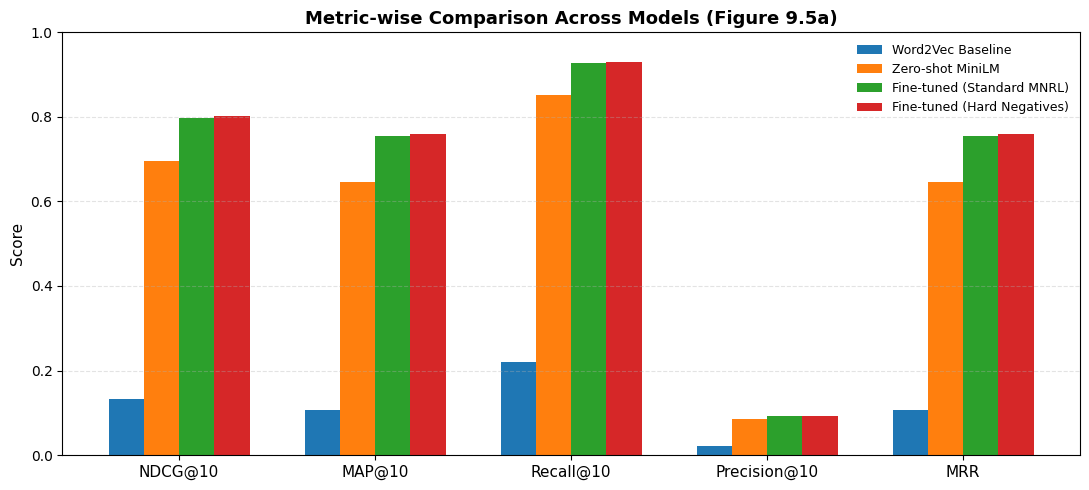

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load unified metrics table
df_all = pd.read_csv(RESULTS_DIR / "all_models_metrics_summary.csv")

# Metrics to analyze
metrics = ["NDCG@10", "MAP@10", "Recall@10", "Precision@10", "MRR"]

# Ensure numeric
for m in metrics:
    df_all[m] = pd.to_numeric(df_all[m], errors="coerce")

# Keep a clean order
model_order = [
    "Word2Vec Baseline",
    "Zero-shot MiniLM",
    "Fine-tuned (Standard MNRL)",
    "Fine-tuned (Hard Negatives)",
]

df_plot = df_all[df_all["Model"].isin(model_order)].set_index("Model").loc[model_order].reset_index()

x = np.arange(len(metrics))
width = 0.18

plt.figure(figsize=(11, 5))

for i, model in enumerate(df_plot["Model"]):
    values = df_plot.loc[df_plot["Model"] == model, metrics].values.flatten()
    plt.bar(
        x + (i - (len(df_plot["Model"]) - 1) / 2) * width,
        values,
        width,
        label=model,
    )

plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Score", fontsize=11)
plt.title(
    "Metric-wise Comparison Across Models (Figure 9.5a)",
    fontsize=13,
    fontweight="bold",
)
plt.ylim(0, 1.0)
plt.legend(frameon=False, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

Interpretation (Figure 9.5a)

From the absolute comparison, the largest differences across models appear in Recall@10, NDCG@10, and MRR, indicating substantial improvements in retrieval coverage and ranking quality as models become more sophisticated.

In contrast, Precision@10 remains relatively stable across the stronger neural models. This suggests that improvements primarily arise from retrieving more relevant documents and ranking them better, rather than increasing precision at a fixed cutoff.

9.5.2 Metric-wise Improvements (Δ Analysis)

To better isolate the effects of different training stages, we next visualize metric deltas:
	•	Standard Fine-tuning − Zero-shot
	•	Hard Negatives − Standard Fine-tuning


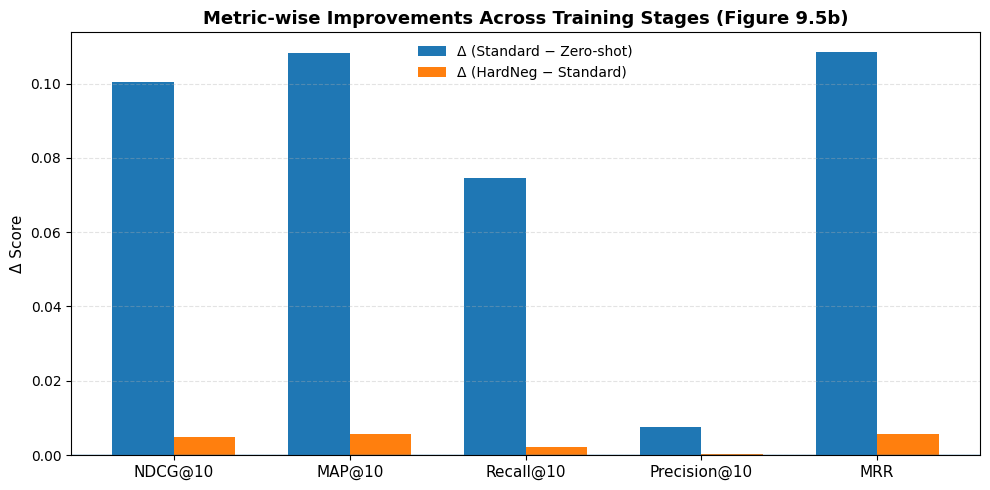

In [79]:
# Helper to extract rows
def row(name):
    return df_plot[df_plot["Model"] == name].iloc[0]

zero = row("Zero-shot MiniLM")
std  = row("Fine-tuned (Standard MNRL)")
hn   = row("Fine-tuned (Hard Negatives)")

delta_ft = np.array([std[m] - zero[m] for m in metrics])
delta_hn = np.array([hn[m]  - std[m]  for m in metrics])

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width / 2, delta_ft, width, label="Δ (Standard − Zero-shot)")
plt.bar(x + width / 2, delta_hn, width, label="Δ (HardNeg − Standard)")

plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Δ Score", fontsize=11)
plt.title(
    "Metric-wise Improvements Across Training Stages (Figure 9.5b)",
    fontsize=13,
    fontweight="bold",
)
plt.axhline(0, linewidth=1)
plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

Interpretation (Figure 9.5b)

The transition from zero-shot to standard fine-tuning yields the largest improvements across nearly all metrics, particularly Recall@10, NDCG@10, and MRR. This highlights the importance of task-specific supervision for semantic retrieval.

In contrast, gains from hard negatives over standard fine-tuning are smaller but consistently positive, reflecting refinement rather than transformation of the learned representations.

9.5.3 Relative Improvements (%): Where the Gains Matter Most

To further emphasize which metrics benefit the most, we compute relative percentage improvements between training stages.

This view is especially helpful for highlighting metrics such as Recall, where absolute gains translate to meaningful coverage improvements.

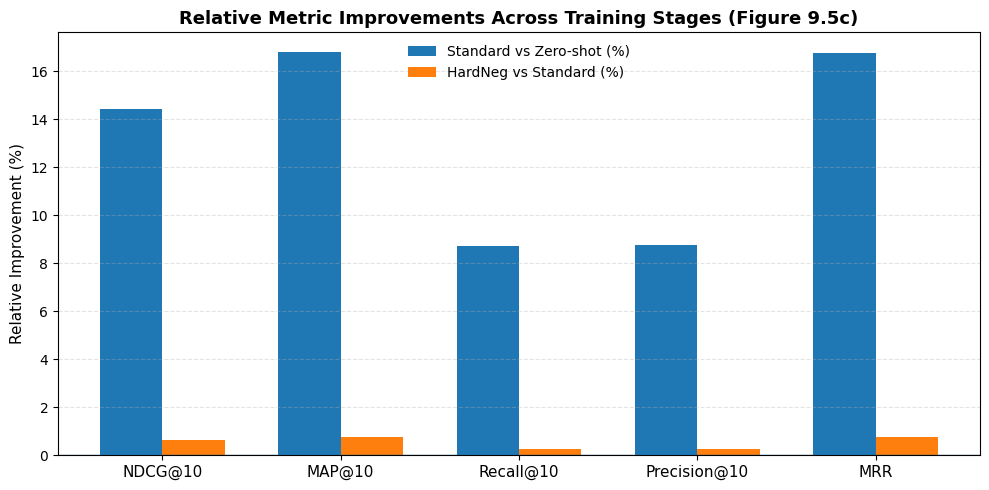

In [80]:
# Relative improvement percentages
rel_ft = np.array([(std[m] - zero[m]) / zero[m] * 100 for m in metrics])
rel_hn = np.array([(hn[m]  - std[m])  / std[m]  * 100 for m in metrics])

plt.figure(figsize=(10, 5))
plt.bar(x - width / 2, rel_ft, width, label="Standard vs Zero-shot (%)")
plt.bar(x + width / 2, rel_hn, width, label="HardNeg vs Standard (%)")

plt.xticks(x, metrics, fontsize=11)
plt.ylabel("Relative Improvement (%)", fontsize=11)
plt.title(
    "Relative Metric Improvements Across Training Stages (Figure 9.5c)",
    fontsize=13,
    fontweight="bold",
)
plt.axhline(0, linewidth=1)
plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

Interpretation (Figure 9.5c)

The relative improvement plot highlights that Recall@10 experiences the largest proportional gains, particularly when moving from zero-shot to fine-tuned models. This indicates that fine-tuning substantially enhances the model’s ability to retrieve a broader set of relevant documents.

In contrast, Precision@10 exhibits smaller relative changes, which is expected for datasets containing multiple relevant documents per query. In such cases, recall and ranking metrics better capture improvements in retrieval quality.

## 9.6 Limitations and Future Work

While the experimental results demonstrate clear and consistent performance gains from fine-tuning and hard negative mining, several limitations remain. These limitations also point to promising directions for future research.

### Limitations

**Representation Capacity of Word2Vec**  
The Word2Vec baseline exhibits substantially lower performance across all evaluation metrics. This limitation arises from its reliance on static, context-independent word embeddings combined with simple averaging for sentence representation. Such representations are unable to capture word sense disambiguation and compositional semantics, which are essential for modern semantic retrieval tasks.

**Bi-encoder Architecture Constraints**  
All neural models evaluated in this work adopt a bi-encoder architecture, which enables efficient large-scale retrieval by encoding queries and documents independently. However, this design prevents explicit modeling of fine-grained token-level interactions between queries and documents, potentially limiting ranking precision, particularly at very small values of *k*.

**Dependence on Hard Negative Quality**  
Although hard negative mining consistently improves retrieval performance, its effectiveness depends heavily on the quality of the negative samples. Poorly selected hard negatives may introduce semantic ambiguity or noise, leading to unstable training behavior or diminishing performance gains.

### Future Work

**Cross-encoder Re-ranking**  
A natural extension of this work is to incorporate a cross-encoder re-ranking stage on top of the bi-encoder retrieval pipeline. By jointly encoding query–document pairs, cross-encoders can capture richer semantic interactions and further improve early-ranking metrics such as MRR and NDCG.

**Advanced Negative Sampling Strategies**  
Future work could explore adaptive or curriculum-based hard negative mining strategies, in which the difficulty of negative samples increases progressively during training. Such approaches may help balance training stability with more discriminative representation learning.

**Scaling to Larger Models and Domains**  
Evaluating larger pre-trained embedding models or extending experiments to domain-specific corpora, such as scientific or biomedical retrieval datasets, would further assess the scalability and generality of the proposed approach.

## 10. Summary

This notebook presents a complete end-to-end semantic retrieval pipeline, covering all major stages from data preparation to evaluation, analysis, and inference. The main components of the system are summarized as follows:

1. **Data Loading and Preprocessing**  
   The SciFact dataset is loaded from HuggingFace and converted into BEIR-compatible format, enabling standardized evaluation and reproducibility.

2. **Model Training**  
   A sentence-transformers model is fine-tuned using **MultipleNegativesRankingLoss**, allowing the model to learn discriminative semantic representations for retrieval tasks.

3. **Evaluation**  
   Model performance is systematically evaluated on the test set using a diverse set of retrieval metrics, including Recall, Precision, MRR, MAP, and NDCG, providing a comprehensive assessment of both coverage and ranking quality.

4. **Analysis**  
   Beyond aggregate metrics, detailed analysis is conducted to examine retrieval behavior across different models, including traditional baselines, zero-shot models, standard fine-tuning, and hard negative fine-tuning. The analysis investigates metric-wise trends, recall–ranking trade-offs, and the impact of hard negatives, offering insight into the mechanisms behind observed performance improvements.

5. **Inference and Retrieval**  
   The trained model is used to perform semantic retrieval, demonstrating its ability to retrieve and rank relevant documents effectively for unseen queries.

Overall, this work highlights the effectiveness of modern embedding-based retrieval models and shows that careful training strategies—particularly hard negative mining—lead to consistent and meaningful improvements in semantic search performance.